### **README FIRST**

This notebook contains material which is (kind of) unrelated to the class project. Feel free to skip sections, and only focus on the sections blow. The rest of the notebook is provided for context and completeness.

1\. [Data Preprocessing](#data-preprocessing)

5\. [Deep Learning](#deep-learning)

7\. [Model Choice & Evaluation](#model-choice--evaluation)

Also note, I have commented out code related to training, data loading, etc. If you do however wish to run the models, or retrain them from scratch, please use the structure in [this github repository](). If you do retrain any models, have in mind that I have used an MPS device, which is known to give slightly different results compared to CUDA or CPU devices, but the results should be very comparable to mine.

# **Heart Sound Classification**

In this project, we aim to classify heart sounds into normal and abnormal categories using various machine learning and deep learning techniques. 

The goal of this notebook is to explore different approaches, and evaluate their performance on this data which naturally contains a significant class imbalance, noise, artifacts in recordings, and variability in heart sound patterns across individuals. Furthermore, the data is not learned directly in its raw audio format; instead, a heavy preprocessing step is applied to convert the audio signals into visual representations that can be effectively utilized by image-based learning models. Lastly, the dataset is very small (about 3000 samples), which poses additional challenges for training robust models. Because of these challenges, the exploration does not focus on training a state-of-the-art model, but rather holds significant educational value.

The [dataset](https://physionet.org/content/challenge-2016/1.0.0/), sourced from the PhysioNet/CinC Challenge 2016, contains heart sound recordings along with their corresponding labels. It is also available on [Kaggle](https://www.kaggle.com/datasets/bjoernjostein/physionet-challenge-2016).



**Table of Contents**

0. [Setup](#setup)

1. [Data Preprocessing](#data-preprocessing)
    * [Audio to Visual Encoding](#audio-to-visual-encoding)
    * [Label Processing](#label-processing)
    * [Data Splitting](#data-splitting)

2. [Exploratory Data Analysis](#exploratory-data-analysis)

    * [Visual Class Differentiation](#visual-class-differentiation)
    * [Average Spectrogram Difference](#average-spectrogram-difference)
    * [Frequency Energy Distribution](#frequency-energy-distribution)
    * [Audio Duration Distribution](#audio-duration-distribution)

3. [CCV Filter-Based Classification](#ccv-filter-based-classification)

    * [Integral Image Thresholding](#integral-image-thresholding)
    * [Sobel Edge Detection](#sobel-edge-detection)
    * [CCV1 Performance Summary](#ccv1-performance-summary)

4. [CCV Feature-Based Learning](#ccv-feature-based-learning)

    * [Statistical Separability](#statistical-separability)
    * [Spatial Gradients Patterns](#spatial-gradients-patterns)
    * [Texture-Based Learning](#texture-based-learning)
    * [CCV2 Performance Summary](#ccv2-performance-summary)

5. [Deep Learning](#deep-learning)
    
    * [Data Loading](#data-loading)
    * [Training & Evaluation Logic](#training--evaluation-logic)
    * [Baseline FNN](#baseline-fnn)
    * [Enhanced FNN](#enhanced-fnn)
    * [Baseline CNN](#baseline-cnn)
    * [Medium CNN](#medium-cnn)
    * [Enhanced CNN](#enhanced-cnn)
    * [Squeeze Excitation CNN](#squeeze-excitation-cnn)
    * [Feature Fusion Network](#feature-fusion-network)
    * [Data Augmented CNN](#data-augmented-cnn)
    * [DL Performance Summary](#deep-learning-performance-summary)

6. [Pre-Trained Transfer Learning](#pre-trained-transfer-learning)

    * [Baseline Resnet Model](#baseline-resnet-model)
    * [Enhanced Resnet Model](#enhanced-resnet-model)
    * [TL Performance Summary](#tl-performance-summary)

7. [Model Choice & Evaluation](#model-choice--evaluation)

## **Setup**

Importing libraries and packages.

```bash
%cd ../
%uv venv .venv
%source activate .venv
!uv pip install -r requirements.txt
%cd src/
```

In [310]:
import os
import glob
import warnings
import copy
from pathlib import Path
from PIL import Image
from IPython.display import Audio, display
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from librosa.feature import melspectrogram
from librosa.display import specshow, waveshow

from scipy.ndimage import sobel
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.metrics import (recall_score, precision_score, 
                             f1_score, fbeta_score, 
                             classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from skimage.feature import hog
from skimage.transform import resize
from skimage.feature import local_binary_pattern

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as VT
from torchvision.models import resnet18, ResNet18_Weights

import torchaudio.transforms as AT

Defining all constant paths.

In [311]:
ROOT_DIR = str(Path.cwd().parents[0])
DATA_DIR = os.path.join(ROOT_DIR, 'data')

DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)

FIG_DIR = os.path.join(ROOT_DIR, 'fig')
os.makedirs(FIG_DIR, exist_ok=True)

FIG_PREPRO_DIR = os.path.join(FIG_DIR, 'preprocessing')
os.makedirs(FIG_PREPRO_DIR, exist_ok=True)
FIG_EDA_DIR = os.path.join(FIG_DIR, 'eda')
os.makedirs(FIG_EDA_DIR, exist_ok=True)
FIG_CCV_DIR = os.path.join(FIG_DIR, 'ccv')
os.makedirs(FIG_CCV_DIR, exist_ok=True)
FIG_DL_DIR = os.path.join(FIG_DIR, 'deep_learning')
os.makedirs(FIG_DL_DIR, exist_ok=True)
FIG_TL_DIR = os.path.join(FIG_DIR, 'transfer_learning')
os.makedirs(FIG_TL_DIR, exist_ok=True)

print(f"root: {ROOT_DIR}")
print(f"data: {DATA_DIR}")
print(f"data processed: {DATA_PROCESSED_DIR}")

TRAINING_SETS = ["training-a", "training-b", "training-c", "training-d", "training-e", "training-f"]

print(f"training sets: {', '.join(i for i in TRAINING_SETS)}")

root: /Users/sepehrakbari/Projects/heart
data: /Users/sepehrakbari/Projects/heart/data
data processed: /Users/sepehrakbari/Projects/heart/data/processed
training sets: training-a, training-b, training-c, training-d, training-e, training-f


## **Data Preprocessing**

### Audio to Visual Encoding

To start our preprocessing, let's explore the data and see we are dealing with. To do so, I'll take the first audio file from each data collection session and work on that as an example throughout this section.

In [144]:
# sample_paths = [
#     os.path.join(DATA_DIR, 'training-a/a0001.wav'), 
#     os.path.join(DATA_DIR, 'training-b/b0001.wav'),
#     os.path.join(DATA_DIR, 'training-c/c0001.wav'),
#     os.path.join(DATA_DIR, 'training-d/d0001.wav'),
#     os.path.join(DATA_DIR, 'training-e/e00001.wav'),
#     os.path.join(DATA_DIR, 'training-f/f0001.wav')
# ]
# names = ['A', 'B', 'C', 'D', 'E', 'F']


# sample_data = []

# for i, path in enumerate(sample_paths):
#     y, sr = librosa.load(path, sr=4000)
#     sample_data.append({'y': y, 'sr': sr, 'name': names[i]})
    
#     print(f"Sample {names[i]}")
#     display(Audio(data=y, rate=sr))

The goal of our preprocessing section is to convert these raw audio files which a neural network cannot directly work with, into an image format that can be fed into a convolutional neural network (CNN). 

To start, lets shift our view to see these audio files as waveforms.

In [145]:
# fig, axs = plt.subplots(2, 3, figsize=(18, 8))
# audio_data = [(x['y'], x['sr'], x['name']) for x in sample_data]
# for i, (y, sr, label) in enumerate(audio_data):
#     row = i // 3
#     col = i % 3
#     waveshow(y, sr=sr, ax=axs[row, col], axis='time', color='tab:red')
#     axs[row, col].set_title(f"Sample {label}")
#     axs[row, col].set_xlabel("Time (s)")
#     axs[row, col].set_ylabel("Amplitude")
#     axs[row, col].grid(True, linestyle='--', alpha=0.5)
    
# plt.suptitle("Waveforms of Sample Audio Clips", fontsize=16, y=1.02)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_PREPRO_DIR, 'sample_waveforms.png'), dpi=300, bbox_inches='tight')
# plt.show()

We can take these waveforms, and apply a Fourier transform to convert them into frequency domain representations called spectrograms. These spectrograms can then be converted into Mel-spectrograms, which better align with human auditory perception. They will ultimately be represented as 2D images, capturing the frequency content over time, and can be used as input to our CNN model.

To create these Mel-spectrograms, we need to define some parameters. We will use the following parameters:

- **Sample Rate**: The number of samples of audio carried per second, this is typically set to around 20-40 thousand Hz, however, since heart sounds are relatively low frequency, we can use a lower sample rate of 4000 Hz.
- **Duration**: The length of each audio clip in seconds. We will standardize all audio clips to a fixed duration of 10 seconds.
- **Number of Mel Bands**: The number of Mel frequency bands to use in the Mel-spectrogram. This will determine the height of our spectrogram images. We will use 128 Mel bands, for a good balance between detail and computational efficiency.
- **FFT Window Size**: The size of the fast fourier transform window, which affects the time and frequency resolution of the spectrogram. If we set this too high, we may lose temporal resolution, and if we set it too low, we may lose frequency resolution. We will use a window size of 2048 samples.
- **Hop Length**: The number of samples between successive frames in the spectrogram. This determines how much overlap there is between adjacent windows. The size of this should be relative to th FFT window, so we will set it to a quarter of the FFT size, which is 512 samples.
- **fixed length**: Something we need to keep in mind is that all our spectograms need to have the same dimensions to get fed into the CNN. To ensure this, we will enforce a fixed number of time frames (width) in our spectrograms. Since our height (N_MELS) is 128, we will set the fixed length to 128 time frames as well to make square inputs.

In [146]:
SAMPLE_RATE = 4000 # samples per second (Hz)
DURATION = 20 # duration of each audio clip (seconds)
N_MELS = 128 # number of Mel bands (height of spectrogram)
N_FFT = 2048 # FFT window size
HOP_LENGTH = 512 # number of samples between frames
FIXED_LENGTH = 128 # fixed time frames (width of spectrogram)

We can include a function in our preprocessing pipeline to ensure that all audio signals are of the same length by either truncating or padding them as necessary.

In [147]:
def fix_length(y, fixed_length, hop_length, n_fft):
    """
    Adjust the length of the audio signal `y` to ensure it results in a spectrogram with `fixed_length` time frames.
    """
    goal = (fixed_length - 1) * hop_length + n_fft
    
    if len(y) > goal:
        # Truncate
        y_out = y[:goal]
    elif len(y) < goal:
        # Pad (with zeros)
        padding_needed = goal - len(y)
        y_out = np.pad(y, (0, padding_needed), mode='constant')
    else:
        y_out = y
    return y_out

Now that everything is set, we can load our audio file using our sample rate, adjust its length, and then convert it into a Mel-spectrogram image. I'll first demonstrate this process on our sample audio files.

In [148]:
# plt.figure(figsize=(15, 15))

# for i, data in enumerate(sample_data):
#     ax = plt.subplot(3, 3, i + 1)
    
#     y = data['y']
#     sr = data['sr']
#     name = data['name']
    
#     y_fixed = fix_length(y, FIXED_LENGTH, HOP_LENGTH, N_FFT)
    
#     mel_spectrogram = melspectrogram(
#         y=y_fixed,
#         sr=sr,
#         n_fft=N_FFT,
#         hop_length=HOP_LENGTH,
#         n_mels=N_MELS
#     )
#     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

#     specshow(
#         mel_spectrogram_db,
#         sr=sr,
#         hop_length=HOP_LENGTH,
#         x_axis='time',
#         y_axis='mel',
#         cmap='Reds',
#         ax=ax
#     )
    
#     plt.title(f'Sample {name}')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Mel Frequency (Hz)')

# for j in range(len(sample_data) + 1, 10):
#     plt.subplot(3, 3, j).set_visible(False)

# plt.suptitle(f'Mel-Spectrograms of Sample Audio Clips', 
#              fontsize=16, y=0.92)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig(os.path.join(FIG_PREPRO_DIR, 'sample_melspectrograms.png'), dpi=300, bbox_inches='tight')
# plt.show()

This shows the Mel-spectrogram of our sample audio file. The x-axis represents time, the y-axis represents Mel frequency bands, and the color intensity indicates the amplitude of each frequency band at each time frame. Of course, since some files are shorter or longer than others, the spectrograms will either be padded with zeros or truncated to ensure they all have the same dimensions.

### Label Processing

Now to save the files for the training process, we define their resolution and load them all in.

In [149]:
DPI = 100
FIGSIZE = (N_MELS / DPI, FIXED_LENGTH / DPI)

def make_melspec(audio_path, output_path):
    """
    Loads and generate Mel-spectrograms.
    """
    try:
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        y_fixed = fix_length(y, FIXED_LENGTH, HOP_LENGTH, N_FFT)

        mel_spectrogram = melspectrogram(
            y=y_fixed, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
        )
        
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        plt.figure(figsize=FIGSIZE, dpi=DPI)
        
        specshow(mel_spectrogram_db, cmap='plasma')
        
        plt.axis('off')
        plt.tight_layout(pad=0)
        
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        return True

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return False

We also have to load our labels (normal/abnormal) from the annotation files. I'll combine all of them into a single dataframe for easier access later on.

Since the dataset comes with its own validation set and different training sets (recorded at different times), I will read all the labels and note where each sample comes from for future reference. Also note, some of these recording are marked as lower quality, and for commercial use they should be excluded, however for academic purposes we can include them all to have more data to train on (this is the recommended approach by the dataset authors).

In [150]:
# def read_labels():
#     """
#     Reads all annotation files and combines them into a single DataFrame.
#     """
#     all_labels = []
    
#     training_annotation_files = glob.glob(os.path.join(DATA_DIR, 'training-*', 'REFERENCE.csv'))
#     val_annotation_file = os.path.join(DATA_DIR, 'validation', 'REFERENCE.csv')
    
#     for file_path in training_annotation_files:
#         try:
#             df = pd.read_csv(file_path, header=None, names=['Name', 'Label'])
#             df['Set'] = os.path.basename(os.path.dirname(file_path))
#             all_labels.append(df)
#         except Exception as e:
#             print(f"Could not read {file_path}. Error: {e}")
    
#     try:
#         df_val = pd.read_csv(val_annotation_file, header=None, names=['Name', 'Label'])
#         df_val['Set'] = 'validation'
#         all_labels.append(df_val)
#     except Exception as e:
#         print(f"Warning: Could not read validation annotation file. Error: {e}")

#     if all_labels:
#         master_df = pd.concat(all_labels, ignore_index=True)
#         master_df['Name'] = master_df['Name'].apply(lambda x: x + '.png')
#         return master_df
#     else:
#         print("ERROR: No labels collected from any file.")
#         return pd.DataFrame()
    
# labels_df = read_labels()
# display(labels_df.sample(5, random_state=325))

The labels are stored in the same format of the annotations. The label is whether the heart beat is normal (-1) or abnormal (1).

In [151]:
# def process_data():
#     """
#     Process all audio files and labels.
#     """
#     data_subfolders = glob.glob(os.path.join(DATA_DIR, 'training-*'))
#     validation_folder = os.path.join(DATA_DIR, 'validation')
    
#     if os.path.isdir(validation_folder):
#         data_subfolders.append(validation_folder)

#     if not data_subfolders:
#         print("No subdirectories found.")
#         return None, None

#     processed = 0
    
#     for folder_idx, subfolder_path in enumerate(data_subfolders):
#         subfolder_name = os.path.basename(subfolder_path)
#         output_subfolder = os.path.join(DATA_PROCESSED_DIR, subfolder_name)
#         os.makedirs(output_subfolder, exist_ok=True)
        
#         wav_files = glob.glob(os.path.join(subfolder_path, '*.wav'))
        
#         print(f"\nProcessing Folder #{folder_idx + 1}: {subfolder_name} ({len(wav_files)} files)")

#         for wav_count, wav_path in enumerate(wav_files):
#             if (wav_count + 1) % 100 == 0:
#                 print(f"Processed {wav_count + 1} of {len(wav_files)}")
            
#             file_name = os.path.basename(wav_path)
#             output_file_name = file_name.replace('.wav', '.png')
#             output_path = os.path.join(output_subfolder, output_file_name)
            
#             if make_melspec(wav_path, output_path): 
#                 processed += 1

#     global_labels_df = read_labels()
    
#     labels_output_path = os.path.join(DATA_PROCESSED_DIR, 'labels_raw.csv')
#     global_labels_df.to_csv(labels_output_path, index=False)
    
#     print(f"\nTotal audio files processed: {processed}")
#     print(f"Total labels collected: {len(global_labels_df)}")
#     print(f"Labels saved to: {labels_output_path}")

#     return global_labels_df, DATA_PROCESSED_DIR

In [152]:
# labels, processed_dir = process_data()

# if labels is not None and not labels.empty:
#     display(labels.head())
#     display(labels['Label'].value_counts())

To make the labels easier to use later on, I will add an additional column to map the file names to their corresponding Mel-spectrogram image files, and also make the labels 0/1 instead of -1/1, this is more standard for binary classification but ultimately does not matter.

In [153]:
LABELS_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels_raw.csv')
labels_df = pd.read_csv(LABELS_PATH)

def get_full_path(row):
    subfolder = row['Set']
    filename = row['Name']
    return os.path.join(DATA_PROCESSED_DIR, subfolder, filename)

labels_df['Image'] = labels_df.apply(get_full_path, axis=1)
labels_df['Label'] = labels_df['Label'].map({-1: 0, 1: 1})

FINAL_DATA_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels.csv')
labels_df.to_csv(FINAL_DATA_PATH, index=False)

print(f"Final dataset shape: {labels_df.shape}")
labels_df.sample(5, random_state=42)

Final dataset shape: (3541, 4)


,Name,Label,Set,Image
712,e00223.png,0,training-e,/Users/sepehrakbari/Projects/heart/data/proces...
279,b0280.png,1,training-b,/Users/sepehrakbari/Projects/heart/data/proces...
1456,e00967.png,1,training-e,/Users/sepehrakbari/Projects/heart/data/proces...
3505,e00266.png,1,validation,/Users/sepehrakbari/Projects/heart/data/proces...
2194,e01705.png,0,training-e,/Users/sepehrakbari/Projects/heart/data/proces...


### Data Splitting

All data is now processed, meaning the Mel-spectrogram images are saved, and the labels dataframe is ready for use in training our model. However, there are two issues to address before we can proceed:

1.  **Class Imbalance**: The dataset is imbalanced, with significantly more normal recordings than abnormal ones. This could lead to a biased model that performs poorly on the minority class. For now, I won't over-sample or under-sample, but I will keep this in mind in future steps.

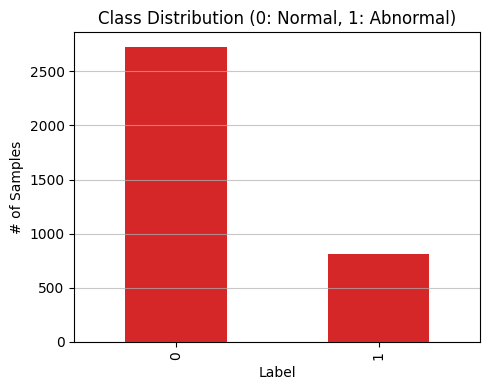

In [154]:
LABELS_PATH = os.path.join(DATA_PROCESSED_DIR, 'labels.csv')
labels_df = pd.read_csv(LABELS_PATH)

plt.figure(figsize=(5, 4))
labels_df['Label'].value_counts().plot(kind='bar', color='tab:red')
plt.title('Class Distribution (0: Normal, 1: Abnormal)')
plt.xlabel('Label')
plt.ylabel('# of Samples')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIG_EDA_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

2. **Val/Train Overlap**: The validation set contains some samples that are also present in the training set, which could lead to data leakage and overly optimistic performance estimates. I will need to ensure that the validation set is truly independent of the training data. This is why I noted where each sample came from in the labels dataframe, so now I will split the data using the 'Set' column, and remove any overlapping samples from the training set.

*Note: I'll take the testing set from the training data later on.*

In [155]:
validation_df = labels_df[labels_df['Set'] == 'validation'].copy()
training_and_test_df_raw = labels_df[labels_df['Set'].str.startswith('training')].copy()

validation_filenames = set(validation_df['Name'])

training_and_test_df = training_and_test_df_raw[
    ~training_and_test_df_raw['Name'].isin(validation_filenames)
].copy()

removed_count = len(training_and_test_df_raw) - len(training_and_test_df)

print(f"Total samples in validation set: {len(validation_df)}")
print(f"Total duplicate samples removed from training sets: {removed_count}")

print(f"\nFinal training/test set shape: {training_and_test_df.shape}")
print(f"Final validation set shape: {validation_df.shape}")

Total samples in validation set: 301
Total duplicate samples removed from training sets: 301

Final training/test set shape: (2939, 4)
Final validation set shape: (301, 4)


Splitting the data by feature and target variables, and then I'll split the data into training and test sets.

Since the total images is 2939 + 301 = 3240, 20% of that is 648, so I'll take 648 samples from the training set as the test set, which is about 22% of the train_test set.

In [156]:
X = training_and_test_df['Image']
y = training_and_test_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.22, 
    random_state=325, 
    stratify=y
)

train_df = pd.DataFrame({'Image': X_train, 'Label': y_train}).reset_index(drop=True)
test_df = pd.DataFrame({'Image': X_test, 'Label': y_test}).reset_index(drop=True)
val_df = validation_df[['Image', 'Label']].reset_index(drop=True)

X_val = val_df['Image']
y_val = val_df['Label']

split_eval = pd.DataFrame({
    'Set': ['Train', 'Test', 'Val'],
    'Total Samples': [len(X_train), len(X_test), len(X_val)],
    'Abnormal (Label=1)': [y_train.sum(), y_test.sum(), y_val.sum()],
    'Normal (Label=0)': [len(X_train) - y_train.sum(), len(X_test) - y_test.sum(), len(X_val) - y_val.sum()]
})

split_eval['Abnormal %'] = (split_eval['Abnormal (Label=1)'] / split_eval['Total Samples'] * 100).round(2)
display(split_eval)

,Set,Total Samples,Abnormal (Label=1),Normal (Label=0),Abnormal %
0,Train,2292,401,1891,17.50
1,Test,647,113,534,17.47
2,Val,301,151,150,50.17


The table above summarizes the distribution of normal and abnormal samples in the training, validation, and test sets. It includes some very good news as well! The training and testing sets are very well split, with about 83% normal and 17% abnormal samples in both sets. This consistency will help the model generalize better. The validation set, however, has about 50% normal and 50% abnormal samples, which is great because we primarily will use validation accuracy to tune hyperparameters and select models, so having a balanced validation set will give us a better estimate of model performance across both classes, and it will help ensure that the model does not overfit to the majority class during training.

## **Exploratory Data Analysis**

### Visual Class Differentiation

Before training any models, it's important to understand the data we're working with. One way to do this is by visually inspecting the Mel-spectrograms of normal and abnormal heart sounds to see if there are any discernible patterns or differences between the two classes.

In [157]:
# all_labels_df = pd.read_csv(f'{DATA_PROCESSED_DIR}/labels.csv')

# sample_indices = ['a0001.png', 'b0001.png', 'c0001.png', 'd0001.png', 'e00001.png', 'f0001.png']
# sets = ['A', 'B', 'C', 'D', 'E', 'F']
# sample_images = all_labels_df[all_labels_df['Name'].isin(sample_indices)].drop_duplicates(subset='Name').reset_index(drop=True)
# sample_images = sample_images.set_index('Name').loc[sample_indices].reset_index()

# max_plots = min(len(sample_images), 9)

# plt.figure(figsize=(10, 12))
# for i in range(max_plots):
#     row = sample_images.iloc[i]
#     img_path = row['Image']
#     label = row['Label']
    
#     img = plt.imread(img_path)
    
#     ax = plt.subplot(3, 3, i + 1)
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(f"Sample {sets[i]} ({'Abnormal' if label == 1 else 'Normal'})")
    
# for j in range(max_plots + 1, 10):
#     plt.subplot(3, 3, j).set_visible(False)
    
# plt.suptitle("Sample Labeled Data", fontsize=16, y=0.9)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig(os.path.join(FIG_PREPRO_DIR, 'sample_labeled_data.png'), dpi=300, bbox_inches='tight')
# plt.show()

From at least this small sample, containing 2 abnormal and 4 normal samples, we can not really see any clear visual differences between the normal and abnormal heart sounds.

### Average Spectrogram Difference

To get a better sense of the overall differences, and spefically using the commonality of the spectograms within each class, we can compute the average Mel-spectrogram for normal and abnormal heart sounds separately, and then visualize the difference between these two average spectrograms.

We'll start by converting each image into a numpy array and computing the mean spectrogram for each class. First, I'll define a function to load and vectorize the spectrogram images with values between 0-255.

In [158]:
# def vectorize_spec(path):
#     """Loads a spectrogram image and converts it to a NumPy array."""
#     try:
#         img = Image.open(path).convert('L') # L mode for grayscale
#         return np.array(img, dtype=np.float32)
#     except Exception as e:
#         print(f"Failed to load {path}: {e}")
#         return None
    
# sample_path = sample_images.iloc[0]['Image']
# spec_array = vectorize_spec(sample_path)
# print(f"Vectorized spectrogram for Sample A: \n\n{spec_array}")

Now We can separate our data into normal and abnormal classes, load their spectrograms, and compute the mean spectrogram for each class.

In [159]:
# normal_paths = all_labels_df[all_labels_df['Label'] == 0]['Image'].tolist()
# abnormal_paths = all_labels_df[all_labels_df['Label'] == 1]['Image'].tolist()

# normal_spectrograms = [vectorize_spec(p) for p in normal_paths if vectorize_spec(p) is not None]
# abnormal_spectrograms = [vectorize_spec(p) for p in abnormal_paths if vectorize_spec(p) is not None]

# mean_normal_spec = np.mean(np.stack(normal_spectrograms), axis=0)
# mean_abnormal_spec = np.mean(np.stack(abnormal_spectrograms), axis=0)

Before we plot, we can also compute the difference between the mean normal and mean abnormal spectrograms to highlight the areas where they differ the most. This may allow us to identify specific frequency bands or time intervals that are more indicative of abnormal heart sounds visually.

We can then visualize the mean spectrograms for normal and abnormal heart sounds, as well as their difference.

In [160]:
# difference_map = mean_abnormal_spec - mean_normal_spec

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle('Average Spectrogram Per Class', fontsize=16)

# specshow(mean_normal_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[0], cmap='Blues')
# axes[0].set_title(f'Mean Normal ({len(normal_spectrograms)} samples)')
# axes[0].set_xlabel('Time Frames')
# axes[0].set_ylabel('Mel Frequency Bins')

# specshow(mean_abnormal_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[1], cmap='Reds')
# axes[1].set_title(f'Mean Abnormal ({len(abnormal_spectrograms)} samples)')
# axes[1].set_xlabel('Time Frames')

# max_abs = np.max(np.abs(difference_map))
# im = specshow(difference_map, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=axes[2], 
#                               cmap='bwr', vmin=-max_abs, vmax=max_abs)
# axes[2].set_title('Difference (Abnormal - Normal)')
# axes[2].set_xlabel('Time Frames')
# fig.colorbar(im, ax=axes[2], format='%+2.f',)

# plt.grid(False)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(os.path.join(FIG_EDA_DIR, 'mean_spectrograms.png'), dpi=300, bbox_inches='tight')
# plt.show()

Observe that in the difference plot, areas where the color is closer to white indicate little to no difference between the two classes. Blue areas indicate that the normal class has higher average intensity in those regions, and red areas indicate that the abnormal class has higher average intensity.

The figures validate that the true signal is time-based and frequency-localized. They can also reveal some characteristics about the two classes:

- The abnormal heart sound is characterized by consistent, higher-frequency spectral content that lasts the entire duration of the recording. This is the signature of a persistent heart murmur or continuous breathing/friction that is high-frequency noise. 

- The normal class has slightly more energy than the Abnormal class in the very low frequencies , which is likely just a statistical artifact or due to the Abnormal data being normalized differently. 

- It's also important to note that this energy is present across the entire 16.7 seconds.

### Frequency Energy Distribution

Beyond visual differences, we can also analyze the distribution of frequency energy across the two classes. This is an important step which can give us some initial clues on how deep our neural models should be. If both lines track closely but the abnormal line is just slightly higher overall, we need a deep CNN to find subtle differences. If there's a big spike in a specific frequency range, we can justify a simple, shallow CNN focused on that area.

In [161]:
# normal_energy_profile = np.mean(mean_normal_spec, axis=1)
# abnormal_energy_profile = np.mean(mean_abnormal_spec, axis=1)

# plt.figure(figsize=(10, 5))

# plt.plot(normal_energy_profile, label='Mean Normal', color='tab:blue', linewidth=2)
# plt.plot(abnormal_energy_profile, label='Mean Abnormal', color='tab:red', linewidth=2)
# plt.title('Average Frequency Energy Per Class')
# plt.xlabel('Mel Frequency Bins')
# plt.ylabel('Mean Energy Intensity')
# plt.grid(True, alpha=0.6, linestyle='--')
# plt.legend()
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_EDA_DIR, 'mean_frequency_energy.png'), dpi=300, bbox_inches='tight')
# plt.show()

This plot reveals that frequency range usage is nearly identical between normal and abnormal classes. Looking closely:

- In low frequencies: Energy is low and identical. This is where the main heart sounds usually live, but on average, there's no overall energy difference here.

- In mid frequencies: Energy rises sharply and tracks almost perfectly between the two classes, until the very highest bins (~100). We can also see some minor fluctuations in the abnormal line here, likely due to the higher frequency content seen in the average spectrogram.

- Spikes: The abnormal line rises slightly faster and higher than the normal line at the highest frequency bins. Have in mind that the sharp decrease at the end is due to the data preprocessing step and does not represent a true drop in energy.

Overall the abnormality is not a broad-band noise issue. If the abnormal class had a lot of background friction or high-frequency patient movement noise, the red line would be significantly higher across the entire spectrum. The subtle difference at the high end suggests that the abnormalities are specific, short-burst events that don't add much to the average energy profile, except possibly in the highest, least meaningful bins (which are often just noise).

### Audio Duration Distribution

In [162]:
# original_durations = []
# for col, row in all_labels_df.iterrows():
#     wav_path = os.path.join(DATA_DIR, row['Set'], row['Name'].replace('.png', '.wav'))
    
#     if os.path.exists(wav_path):
#         try:
#             duration = librosa.get_duration(path=wav_path, sr=SAMPLE_RATE)
#             original_durations.append(duration)
#         except Exception:
#             continue

# plt.figure(figsize=(10, 5))

# fixed_duration = (128 - 1) * 512 + 2048 # this formula comes from the spectrogram parameters defined earlier
# fixed_duration_seconds = fixed_duration / SAMPLE_RATE

# plt.hist(original_durations, bins=50, color='tan', alpha=0.7)
# plt.axvline(fixed_duration_seconds, 
#             color='saddlebrown', linewidth=2, linestyle='--',
#             label=f'Fixed Length ({fixed_duration_seconds:.1f} seconds)')
# plt.title('Distribution of Original Audio Recording Durations')
# plt.xlabel('Duration (Seconds)')
# plt.ylabel('# of Recordings')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_EDA_DIR, 'durations_distribution.png'), dpi=300, bbox_inches='tight')
# plt.show()

This plot shows how varied the original audio recording lengths are in our dataset. This definitely justifies our preprocessing step of enforcing a fixed length for all audio samples, and adding padding or truncating as necessary. Our choice of the 16.8 seconds fixed length seems appropriate, as it provides a good balance between covering many recordings fully, while not being excessively long and adding too much padding for shorter samples.

Have in mind that this balance is very important, cause we don't want our neural network to learn from the padding segments, or the noise introduced by truncating the audio.

## **CCV Filter-Based Classification**



### Integral Image Thresholding

Now that we have a good understanding of our data, and have justified our preprocessing choices, we can move on to building our first classification model!

Since we have already how the intensity distribution varies across frequency bands for the two classes, we can start with classifying based on these intensities directly, using a simple thresholding approach. In classical computer vision (CCV), there exists a method called Integral Images, also known as Summed Area Tables, which allows for us to compute the average energy in the most differentiated area of the spectrogram.

Based on our EDA, we can see that the most differentiated area is in the higher frequency bands, so we can focus our classification on just the top half of the spectrogram. I'll implement this to take in an image and compute the average intensity in the top half of the spectrogram, and use that as a feature for classification.

In [163]:
# def mean_img(image_path):
#     """
#     Extracts the overall average energy from the spectrogram.
#     """
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.float32)
#     except Exception:
#         return 0.0 

#     return np.mean(spec_array) # overall average energy

# def intgrl_img(image_path, n_mels=128):
#     """
#     Extracts the average energy from the high-frequency half of the spectrogram.
#     """
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.float32)
#     except Exception:
#         return 0.0 

#     top_half = spec_array[n_mels // 2:, :]
#     return np.mean(top_half) # average energy of top half frequencies

# sample_image_path = sample_images.iloc[0]['Image']
# high_freq_energy = intgrl_img(sample_image_path)
# overall_energy = mean_img(sample_image_path)

# print(f"mean of overall energy (Sample A): {overall_energy:.2f}")
# print(f"mean of high-frequency energy (Sample A): {high_freq_energy:.2f}")

Next, I'll define a threshold based on the average high-frequency energy computed from the training set. In this approach, let any sample with a 5% higher high-frequency energy than this threshold be classified as abnormal, otherwise normal.

In [164]:
# normal_train_df = train_df[train_df['Label'] == 0]

# normal_features_ccv1_b1 = normal_train_df['Image'].apply(intgrl_img).values

# threshold_mean_ccv1_b1 = np.mean(normal_features_ccv1_b1)
# threshold_ccv1_b1 = threshold_mean_ccv1_b1 * 1.05

# print(f"Mean high-freq energy for normal training data: {threshold_mean_ccv1_b1:.2f}")
# print(f"Classification threshold (mu + 5%): {threshold_ccv1_b1:.2f}")

Let's test this simple classifier on our test set and see how well it performs.

In [165]:
# test_features_ccv1_b1 = test_df['Image'].apply(intgrl_img).values
# test_true_ccv1_b1 = test_df['Label'].values

# test_pred_ccv1_b1 = (test_features_ccv1_b1 > threshold_ccv1_b1).astype(int)

# rec_t_ccv1_b1 = recall_score(test_true_ccv1_b1, test_pred_ccv1_b1, pos_label=1) * 100
# prec_t_ccv1_b1 = precision_score(test_true_ccv1_b1, test_pred_ccv1_b1, pos_label=1) * 100
# f1_t_ccv1_b1 = f1_score(test_true_ccv1_b1, test_pred_ccv1_b1, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_t_ccv1_b1:.1f}% \
#     Abnormal Precision: {prec_t_ccv1_b1:.1f}% \
#     Abnormal F1: {f1_t_ccv1_b1:.1f}%\n")
# print(classification_report(test_true_ccv1_b1, test_pred_ccv1_b1, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(test_true_ccv1_b1, test_pred_ccv1_b1)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv1_b1_test_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

The results reveal that this model is just slightly better than random guessing! Which is not very surprising given the very subtle differences we observed in the EDA. Moreover, observe that although our accuracy is around 51%, the precision for the abnormal class is at about 14%, which stems from the class imbalance in the test set. This means that when the model predicts a sample as abnormal, it's only correct about 14% of the time, which is quite low. This would also mean that we could simply increase the threshold to classify almost all samples as normal, and achieve a high accuracy but of course be left with a useless model. The recall of 33% for the abnormal class indicates that the model is only identifying a third of the actual abnormal cases, which is also quite low.

To demonstrate this further, this is the same classification done on the validation set, which is balanced between normal and abnormal samples.

In [166]:
# val_features_ccv1_b1 = val_df['Image'].apply(intgrl_img).values
# val_true_ccv1_b1 = val_df['Label'].values

# val_pred_ccv1_b1 = (val_features_ccv1_b1 > threshold_ccv1_b1).astype(int)

# rec_v_ccv1_b1 = recall_score(val_true_ccv1_b1, val_pred_ccv1_b1, pos_label=1) * 100
# prec_v_ccv1_b1 = precision_score(val_true_ccv1_b1, val_pred_ccv1_b1, pos_label=1) * 100
# f1_v_ccv1_b1 = f1_score(val_true_ccv1_b1, val_pred_ccv1_b1, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv1_b1:.1f}% \
#     Abnormal Precision: {prec_v_ccv1_b1:.1f}% \
#     Abnormal F1: {f1_v_ccv1_b1:.1f}%\n")
# print(classification_report(val_true_ccv1_b1, val_pred_ccv1_b1, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(val_true_ccv1_b1, val_pred_ccv1_b1)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv1_b1_val_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

Here, the accuracy is around 46.5%, so even worse than random guessing, but the precision for both classes is about the same at around 50%. Of course, we see a better recall for the normal set, since the model is biased towards predicting normal due to the threshold being based on the training set distribution.

### Sobel Edge Detection

Our second filter-based CCV approach will explore whether how often the noise starts and stops in the spectrogram can be used as a differentiating factor between normal and abnormal heart sounds. The idea here is that abnormal heart sounds may have more abrupt changes in frequency content due to murmurs or other irregularities. These could be captured as edges in the spectrogram image.

I will implement (using SciPy) a standard edge detection filter, the Sobel filter, to identify these abrupt changes in the spectrograms. The Sobel filter computes the gradient of the image intensity, highlighting areas with high spatial frequency which correspond to edges.

In [167]:
# def edges_img(image_path):
#     """
#     Takes an image path, applies Sobel edge detection, and returns image with edges highlighted.
#     """
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.float32)
#     except Exception:
#         return None 

#     edge_detection = np.abs(sobel(spec_array, axis=1))
    
#     return edge_detection

# def count_edges(spec_array, n_mels=128):
#     """Extracts the sum of vertical edges in the high-frequency half."""
#     if spec_array is None: 
#         return 0.0
    
#     edge_detection = np.abs(sobel(spec_array, axis=1))
    
#     high_freq_edges = edge_detection[n_mels // 2:, :]
    
#     return np.sum(high_freq_edges)

# img1 = sample_images.iloc[0]['Image']
# img2 = sample_images.iloc[5]['Image']

# edge_img1 = edges_img(img1)
# edge_img2 = edges_img(img2)

# edge_img1_count = count_edges(vectorize_spec(img1))
# edge_img2_count = count_edges(vectorize_spec(img2))

# fig, axes = plt.subplots(2, 2, figsize=(9,9))

# axes[0, 0].imshow(plt.imread(img1), cmap='gray')
# axes[0, 0].set_title(f'Sample A {"(Abnormal)" if sample_images.iloc[0]["Label"] == 1 else "(Normal)"}')
# axes[0, 0].axis('off')

# axes[0, 1].imshow(edge_img1, cmap='inferno')
# axes[0, 1].set_title(f'Sample A Edges (count: {edge_img1_count:.0f})')
# axes[0, 1].axis('off')

# axes[1, 0].imshow(plt.imread(img2), cmap='gray')
# axes[1, 0].set_title(f'Sample F {"(Abnormal)" if sample_images.iloc[5]["Label"] == 1 else "(Normal)"}')
# axes[1, 0].axis('off')

# axes[1, 1].imshow(edge_img2, cmap='inferno')
# axes[1, 1].set_title(f'Sample F Edges (count: {edge_img2_count:.0f})')
# axes[1, 1].axis('off')

# plt.suptitle('Sobel Edge Detection on Sample Spectrograms', fontsize=16, y=0.92)
# plt.tight_layout(rect=[0, 0.03, 1, 0.9])
# plt.savefig(os.path.join(FIG_CCV_DIR, 'sample_sobel_edges.png'), dpi=300, bbox_inches='tight')
# plt.show()

The figure above shows the Sobel edge detection applied to two sample spectrograms. Regardless of being normal or abnormal, the edges are highlighted in bright colors, indicating areas where there are abrupt changes in frequency content. This directly reflects the transitions in the heart sounds, such as the onset and offset of heartbeats and any irregularities present.

Next, I'll test it again on both the test and validation sets, using the same thresholding method as before, but this time based on the count of detected edges in the spectrograms.

In [168]:
# normal_features_ccv1_b2 = normal_train_df['Image'].apply(vectorize_spec).apply(count_edges).values

# threshold_mean_ccv1_b2 = np.mean(normal_features_ccv1_b2)
# threshold_ccv1_b2 = threshold_mean_ccv1_b2 * 1.05

# print(f"Mean count of edges for normal training data: {threshold_mean_ccv1_b2:.2f}")
# print(f"Classification threshold (mu + 5%): {threshold_ccv1_b2:.2f}")

In [169]:
# test_features_ccv1_b2 = test_df['Image'].apply(vectorize_spec).apply(count_edges).values
# test_true_ccv1_b2 = test_df['Label'].values

# test_pred_ccv1_b2 = (test_features_ccv1_b2 > threshold_ccv1_b2).astype(int)

# rec_t_ccv1_b2 = recall_score(test_true_ccv1_b2, test_pred_ccv1_b2, pos_label=1) * 100
# prec_t_ccv1_b2 = precision_score(test_true_ccv1_b2, test_pred_ccv1_b2, pos_label=1) * 100
# f1_t_ccv1_b2 = f1_score(test_true_ccv1_b2, test_pred_ccv1_b2, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_t_ccv1_b2:.1f}% \
#     Abnormal Precision: {prec_t_ccv1_b2:.1f}% \
#     Abnormal F1: {f1_t_ccv1_b2:.1f}%\n")
# print(classification_report(test_true_ccv1_b2, test_pred_ccv1_b2, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(test_true_ccv1_b2, test_pred_ccv1_b2)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv1_b2_test_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [170]:
# val_features_ccv1_b2 = val_df['Image'].apply(vectorize_spec).apply(count_edges).values
# val_true_ccv1_b2 = val_df['Label'].values

# val_pred_ccv1_b2 = (val_features_ccv1_b2 > threshold_ccv1_b2).astype(int)

# rec_v_ccv1_b2 = recall_score(val_true_ccv1_b2, val_pred_ccv1_b2, pos_label=1) * 100
# prec_v_ccv1_b2 = precision_score(val_true_ccv1_b2, val_pred_ccv1_b2, pos_label=1) * 100
# f1_v_ccv1_b2 = f1_score(val_true_ccv1_b2, val_pred_ccv1_b2, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv1_b2:.1f}% \
#     Abnormal Precision: {prec_v_ccv1_b2:.1f}% \
#     Abnormal F1: {f1_v_ccv1_b2:.1f}%\n")
# print(classification_report(val_true_ccv1_b2, val_pred_ccv1_b2, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(val_true_ccv1_b2, val_pred_ccv1_b2)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv1_b2_val_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

The results on this test show significant improvement over the previous integral image method! The accuracy on the test set is now 74%, but more importantly, the precision for the abnormal class almost tripled to nearly 40%. The results on the validation set, although lower than the test set, show more balanced performance between the two classes. This is a good sign that the edge-based features are more effective at capturing the characteristics of abnormal heart sounds, not only compared to the integral image method, but also in comparison with classifying normal heart sounds. However this also introduces an issue, since the model performance is so reliant on class balance, it may not generalize well to real-world data where the class distribution is skewed. In training our more sophisticated models later on, we will need to address this class imbalance more directly.

### CCV1 Performance Summary

Up until now, we have used accuracy, precision, and recall on the basis of our minority class (abnormal) to evaluate our models. We will continue to look at recall and precision, along with the F1 score, which balances both metrics. This will give us a more holistic view of model performance.

Moreover, we will begin using the F-Beta (F2) score, which weights recall higher than precision, to better capture the importance of identifying abnormal heart sounds. We will continue to use this metric throughout the rest of the project to evaluate the general 'usefulness' of our models, since in a medical context, it's often more critical to identify as many abnormal cases as possible (high recall), even if it means having some false positives (lower precision).

In [171]:
# fbeta_t_ccv1_b1 = fbeta_score(test_true_ccv1_b1, test_pred_ccv1_b1, beta=2, pos_label=1) * 100
# fbeta_t_ccv1_b2 = fbeta_score(test_true_ccv1_b2, test_pred_ccv1_b2, beta=2, pos_label=1) * 100

# fbeta_v_ccv1_b1 = fbeta_score(val_true_ccv1_b1, val_pred_ccv1_b1, beta=2, pos_label=1) * 100
# fbeta_v_ccv1_b2 = fbeta_score(val_true_ccv1_b2, val_pred_ccv1_b2, beta=2, pos_label=1) * 100

# fbeta_metrics = pd.DataFrame({
#     'Model': ['CCV1-B1', 'CCV1-B2'],
#     'Test Set': [fbeta_t_ccv1_b1, fbeta_t_ccv1_b2],
#     'Val Set': [fbeta_v_ccv1_b1, fbeta_v_ccv1_b2]
# })  

# metrics_ccv1 = pd.DataFrame({
#     'Model': ['CCV1-B1', 'CCV1-B2'],
#     'Test Recall': [rec_t_ccv1_b1, rec_t_ccv1_b2],
#     'Test Precision': [prec_t_ccv1_b1, prec_t_ccv1_b2],
#     'Test F1': [f1_t_ccv1_b1, f1_t_ccv1_b2],
#     'Val Recall': [rec_v_ccv1_b1, rec_v_ccv1_b2],
#     'Val Precision': [prec_v_ccv1_b1, prec_v_ccv1_b2],
#     'Val F1': [f1_v_ccv1_b1, f1_v_ccv1_b2]
# })

# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# metrics_melted = metrics_ccv1.melt(id_vars='Model', var_name='Metric', value_name='Value')
# sns.barplot(data=metrics_melted, x='Metric', y='Value', hue='Model', palette='Set2', edgecolor='white', ax=axes[0])
# axes[0].set_title('Filter-Based Models Performance')
# axes[0].set_ylabel('Performance (%)')
# axes[0].set_xlabel('')
# axes[0].set_ylim(0, 100)
# axes[0].tick_params(axis='x', rotation=45)
# model_names = {
#     'CCV1-B1': 'CCV1-B1 (Integral Image Model)',
#     'CCV1-B2': 'CCV1-B2 (Edge Detection Model)'
# }
# handles, labels = axes[0].get_legend_handles_labels()
# new_labels = [model_names.get(label, label) for label in labels]
# axes[0].legend(handles, new_labels, title='Model', loc='upper right')

# fbeta_melted = fbeta_metrics.melt(id_vars='Model', var_name='Dataset', value_name='F2 Score')
# sns.barplot(data=fbeta_melted, x='Model', y='F2 Score', hue='Dataset', palette='Accent', edgecolor='white', ax=axes[1])
# axes[1].set_title('Filter-Based Models F-Beta Scores')
# axes[1].set_ylabel('F-Beta (%)')
# axes[1].set_xlabel('')
# axes[1].set_ylim(0, 100)
# axes[1].tick_params(axis='x', rotation=45)
# axes[1].legend(title='Dataset', loc='upper right')

# plt.suptitle('CCV1 Models Evaluation', fontsize=18, y=1.02)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv1_performance.png'), dpi=300, bbox_inches='tight')
# plt.show()

The figure above summarizes our filter-based CCV classification results. The results show a clear better performance of the edge-detection based method over the integral image method across all metrics, especially for the abnormal class. Rather unexpectedly, the edge-detection method performs better on the test set than the validation set, which may be due to the class balance in the validation set making it harder for the model to distinguish between classes based on edge counts alone. This means when we have more abnormal images in the set, the model struggles more to find a good threshold that separates the two classes effectively.

Overall, the filter-based approach, especially edge detection, is a promising direction, and suggests that further exploration of edge-based features or more advanced CCV techniques could yield even better classification performance, especially when combined with machine learning models that can learn more complex decision boundaries based on these features, moving beyond the simple linear thresholding used here.

## **CCV Feature-Based Learning**

In this feature-based CCV approach, we will extract a set of features from the Mel-spectrogram images, and use these features to train a machine learning classifier. This approach allows us to capture more complex patterns in the data compared to the simple linear thresholding methods used previously.

### Statistical Separability

Our first model will focus on statistical characteristics of the spectrogram images. In the EDA, we observed that the overall intensity distributions are quite similar between normal and abnormal classes, but now we will look for more subtle statistical differences to see if we can find features that can help separate the two classes.

On top of the standard global statistics extraction, which includes mean and variance, we will also extract the high-frequency energy (HFE) feature we used in the integral image method, as well as some higher-order statistics like skewness and kurtosis, which can capture asymmetry and peakedness in the intensity distributions that may differ between classes.

In [172]:
# def get_stats(image_path, n_mels=128):
#     """Extracts statistical features from a spectrogram."""
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.float32)
        
#         if spec_array is None or spec_array.size == 0:
#             return None
        
#         mean_intensity = np.mean(spec_array)
#         std_intensity = np.std(spec_array)
#         skewness = skew(spec_array.flatten())
#         kurt = kurtosis(spec_array.flatten())
        
#         high_freq_region = spec_array[n_mels // 2:, :]
#         hfe = np.mean(high_freq_region)
        
#         return [mean_intensity, std_intensity, skewness, kurt, hfe]
    
#     except Exception:
#         return None
    
# sample_image_path = sample_images.iloc[0]['Image']
# features = get_stats(sample_image_path)
# print(f"Extracted features from Sample A: \n{features}")

Now we will extract all the features from our datasets.

In [173]:
# X_train_ccv2_b1_feats = np.array([get_stats(p) for p in X_train.values if get_stats(p) is not None])
# y_train_ccv2_b1_aligned = y_train.loc[X_train.index[~pd.Series([get_stats(p) for p in X_train.values]).isna().values]]

# X_test_ccv2_b1_feats = np.array([get_stats(p) for p in X_test.values if get_stats(p) is not None])
# y_test_ccv2_b1_aligned = y_test.loc[X_test.index[~pd.Series([get_stats(p) for p in X_test.values]).isna().values]]

# X_val_ccv2_b1_feats = np.array([get_stats(p) for p in validation_df['Image'] if get_stats(p) is not None])
# y_val_ccv2_b1_aligned = validation_df.loc[validation_df.index[~pd.Series([get_stats(p) for p in validation_df['Image']]).isna().values]]['Label'].values

# print(f"Shape of extracted features:\n")
# print(f"Train: {X_train_ccv2_b1_feats.shape}")
# print(f"Test: {X_test_ccv2_b1_feats.shape}")
# print(f"Validation: {X_val_ccv2_b1_feats.shape}")

To build a classifier, we will use Support Vector Machines (SVM) with a radial basis function (RBF) kernel. This will ensure that we can capture non-linear decision boundaries in the feature space, which is likely necessary given the subtle differences between classes observed in the EDA. The reason for choosing SVM is its ability to find non-linear decision boundaries using kernel functions, which is particularly useful when the classes are not linearly separable in the original feature space.

Given the sensitivity of SVM, we will scale our features, and then define our SVM model. In its parameters, I will use RBF kernel as mentioned, with a regularization parameter C of 10 to allow some flexibility in the decision boundary, and 'scale' for gamma to adapt to the feature space. I will also use balanced class weights to address the class imbalance in the training data. 

In [174]:
# scaler_ccv2_b1 = StandardScaler()

# X_train_ccv2_b1_scaled = scaler_ccv2_b1.fit_transform(X_train_ccv2_b1_feats)
# X_test_ccv2_b1_scaled = scaler_ccv2_b1.transform(X_test_ccv2_b1_feats)
# X_val_ccv2_b1_scaled = scaler_ccv2_b1.transform(X_val_ccv2_b1_feats)

# svm_ccv2_b1 = SVC(kernel='rbf', C=10, gamma='scale', random_state=325, class_weight='balanced')

# svm_ccv2_b1.fit(X_train_ccv2_b1_scaled, y_train_ccv2_b1_aligned)
# y_pred_test_ccv2_b1 = svm_ccv2_b1.predict(X_test_ccv2_b1_scaled)
# y_pred_val_ccv2_b1 = svm_ccv2_b1.predict(X_val_ccv2_b1_scaled)

# rec_t_ccv2_b1 = recall_score(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1, pos_label=1) * 100
# prec_t_ccv2_b1 = precision_score(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1, pos_label=1) * 100
# f1_t_ccv2_b1 = f1_score(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv1_b2:.1f}% \
#     Abnormal Precision: {prec_v_ccv1_b2:.1f}% \
#     Abnormal F1: {f1_v_ccv1_b2:.1f}%\n")
# print(classification_report(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b1_test_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [175]:
# rec_v_ccv2_b1 = recall_score(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1, pos_label=1) * 100
# prec_v_ccv2_b1 = precision_score(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1, pos_label=1) * 100
# f1_v_ccv2_b1 = f1_score(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv2_b1:.1f}% \
#     Abnormal Precision: {prec_v_ccv2_b1:.1f}% \
#     Abnormal F1: {f1_v_ccv2_b1:.1f}%\n")
# print(classification_report(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b1_val_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

The results from this statistical feature-based SVM model show a slight overall improvement over the previous filter-based methods. Perhaps the most notable improvement is in the recall for the abnormal class on the test set, which is now the same as the recall for the normal class at about 67%. This indicates that the model is now equally effective at identifying both normal and abnormal heart sounds, which is a significant step forward. Our main point of concern should be the precision for the abnormal class, which we will work to improve in future models.

This is definetely not a very strong model yet, but it shows that even simple statistical features can provide some useful information for classification, and can be seen as a logical improvement of our integral image thresholding method from before.

### Spatial Gradients Patterns

Next, we will explore an improvement over the previous edge-detection based CCV method, by training a model on Histogram of Oriented Gradients (HOG) features extracted from the spectrogram images. HOG features capture the distribution of gradient orientations in localized regions of the image, which can provide more detailed information about the texture and structure. However, for this data, HOG features will essentially capture a more nuanced edge patterns compared to the simple edge counts used previously, which makes it a natural extension of that method.

HOG feature extraction is computationally intensive, so I'll choose balanced parameters that provide a good trade-off between detail and efficiency. I'll choose 16x16 pixel cells since it divides our 128x128 images evenly into 8 cells along each dimension. I'll use 2x2 cells per block to capture local spatial relationships, and 10 orientation bins to capture a good range of gradient directions. Let's see how this looks first before extracting features from the entire dataset.

In [176]:
# hog_orientations = 10
# hog_pixels_per_cell = (16, 16)
# hog_cells_per_block = (2, 2)

# img1 = sample_images.iloc[0]['Image']
# img2 = sample_images.iloc[5]['Image']

# img1 = Image.open(img1).convert('L')
# img2 = Image.open(img2).convert('L')

# img_arr1 = np.array(img1, dtype=np.float32)
# img_arr2 = np.array(img2, dtype=np.float32)

# hog1, hog_image1 = hog(
#     img_arr1, 
#     orientations=hog_orientations,
#     pixels_per_cell=hog_pixels_per_cell,
#     cells_per_block=hog_cells_per_block,
#     visualize=True
# )

# hog2, hog_image2 = hog(
#     img_arr2, 
#     orientations=hog_orientations,
#     pixels_per_cell=hog_pixels_per_cell,
#     cells_per_block=hog_cells_per_block,
#     visualize=True
# )

# fig, axes = plt.subplots(2, 2, figsize=(9,9))
# axes[0, 0].imshow(img_arr1, cmap='magma')
# axes[0, 0].set_title(f'Sample A {"(Abnormal)" if sample_images.iloc[0]["Label"] == 1 else "(Normal)"}')
# axes[0, 0].axis('off')

# axes[0, 1].imshow(hog_image1, cmap='inferno')
# axes[0, 1].set_title('Sample A HOG Features')
# axes[0, 1].axis('off')

# axes[1, 0].imshow(img_arr2, cmap='magma')
# axes[1, 0].set_title(f'Sample F {"(Abnormal)" if sample_images.iloc[5]["Label"] == 1 else "(Normal)"}')
# axes[1, 0].axis('off')

# axes[1, 1].imshow(hog_image2, cmap='inferno')
# axes[1, 1].set_title('Sample F HOG Features')
# axes[1, 1].axis('off')

# plt.suptitle('HOG Feature Extraction on Sample Spectrograms', fontsize=16, y=0.92)
# plt.tight_layout(rect=[0, 0.03, 1, 0.9])
# plt.savefig(os.path.join(FIG_CCV_DIR, 'sample_hog_features.png'), dpi=300, bbox_inches='tight')
# plt.show()

This is looking good since the parameters seem to capture the edge patterns well. Now we can proceed to extract HOG features from all spectrogram images in our datasets. This will produce a feature vector we can use to train a classifier.

In [177]:
# def get_hog(image_path):
#     """Normalizes, and extracts HOG feature vector."""
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.float32)
        
#         spec_array /= 255.0
        
#         features = hog(
#             spec_array, 
#             orientations=10,
#             pixels_per_cell=(16, 16),
#             cells_per_block=(2, 2),
#             transform_sqrt=True, # for noise reduction
#             feature_vector=True
#         )
#         return features

#     except:
#         return None
    
# X_train_ccv2_b2_feats = [get_hog(p) for p in X_train.values]
# X_train_ccv2_b2_feats = np.array([f for f in X_train_ccv2_b2_feats if f is not None])
# y_train_ccv2_b2_aligned = y_train.loc[X_train.index[:len(X_train_ccv2_b2_feats)]].values


# X_test_ccv2_b2_feats = [get_hog(p) for p in X_test.values]
# X_test_ccv2_b2_feats = np.array([f for f in X_test_ccv2_b2_feats if f is not None])
# y_test_ccv2_b2_aligned = y_test.loc[X_test.index[:len(X_test_ccv2_b2_feats)]].values

# X_val_ccv2_b2_feats = np.array([get_hog(p) for p in validation_df['Image'] if get_hog(p) is not None])
# X_val_ccv2_b2_feats = np.array([f for f in X_val_ccv2_b2_feats if f is not None])
# y_val_ccv2_b2_aligned = validation_df['Label'].values[:len(X_val_ccv2_b2_feats)]

# print(f"Shape of extracted features:\n")
# print(f"Train: {X_train_ccv2_b2_feats.shape}")
# print(f"Test: {X_test_ccv2_b2_feats.shape}")
# print(f"Validation: {X_val_ccv2_b2_feats.shape}")

We have extracted 1680 HOG features from each spectrogram image. Similar to before we are going to use a classifier to train on these features. However, since the feature space is now much larger, it's better to use Random Forest instead of SVM, which is more ideal for high-dimensional spaces and sparse data. 

I will still scale the features before training, more for consistency than necessity. For the Random Forest model, I will use 200 estimators to ensure a robust ensemble, with balanced class weights to address the class imbalance, and a max depth of 10 to prevent overfitting, as this will be a very likely scenario given the high dimensionality of the feature space. The n_jobs parameter is set to -1 to make the training faster on CPU.

In [178]:
# scaler_ccv2_b2 = StandardScaler()
# X_train_ccv2_b2_scaled = scaler_ccv2_b2.fit_transform(X_train_ccv2_b2_feats)
# X_test_ccv2_b2_scaled = scaler_ccv2_b2.transform(X_test_ccv2_b2_feats)
# X_val_ccv2_b2_scaled = scaler_ccv2_b2.transform(X_val_ccv2_b2_feats)

# rf_ccv2_b2 = RandomForestClassifier(
#     n_estimators=20,
#     max_depth=10,
#     random_state=325, 
#     class_weight='balanced',
#     n_jobs=-1
# )

# rf_ccv2_b2.fit(X_train_ccv2_b2_scaled, y_train_ccv2_b2_aligned)
# y_pred_test_ccv2_b2 = rf_ccv2_b2.predict(X_test_ccv2_b2_scaled)
# y_pred_val_ccv2_b2 = rf_ccv2_b2.predict(X_val_ccv2_b2_scaled)

# rec_t_ccv2_b2 = recall_score(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2, pos_label=1) * 100
# prec_t_ccv2_b2 = precision_score(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2, pos_label=1) * 100
# f1_t_ccv2_b2 = f1_score(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_t_ccv2_b2:.1f}% \
#     Abnormal Precision: {prec_t_ccv2_b2:.1f}% \
#     Abnormal F1: {f1_t_ccv2_b2:.1f}%\n")
# print(classification_report(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b2_test_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [179]:
# rec_v_ccv2_b2 = recall_score(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2, pos_label=1) * 100
# prec_v_ccv2_b2 = precision_score(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2, pos_label=1) * 100
# f1_v_ccv2_b2 = f1_score(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv2_b2:.1f}% \
#     Abnormal Precision: {prec_v_ccv2_b2:.1f}% \
#     Abnormal F1: {f1_v_ccv2_b2:.1f}%\n")
# print(classification_report(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b2_val_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

This approach was very successful as expected! The Random Forest model trained on HOG features significantly outperforms all previous CCV methods across all metrics. The predictions on the validation set are lower, because of the domain shift, but still very good for a CCV method. The only downside is the recall which was somewhat higher in the previous statistical feature-based SVM model, meaning more abnormal samples were correctly identified there. However, the precision and overall F1 score improvements make this a worthwhile trade-off, assuring that the abnormal predictions made by the model are more reliable.

### Texture-Based Learning

Next, we will explore another very well-known domain in CCV, which is texture analysis. We will extract texture features using Local Binary Patterns (LBP) from the spectrogram images. LBP is a simple yet powerful texture descriptor that captures the local spatial patterns in an image by comparing each pixel to its neighbors. This can be particularly useful for our spectrograms, capturing temporal dynamics.

I'll start by implementing LBP on a sample spectrogram image to see how it captures the texture patterns. For this task, I'll use 8 neighboring pixels and a radius of 1 pixel, which is a common choice for LBP. The method used will be 'uniform', which is known to be more robust to noise and captures more meaningful patterns.

In [180]:
# def show_lbp(image_path, n_points=10, radius=1):
#     """Returns LBP image and histogram for a given spectrogram."""
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.uint8)
        
#         lbp = local_binary_pattern(spec_array, P=n_points, R=radius, method='uniform')
        
#         (hist, _) = np.histogram(lbp.ravel(),
#                                  bins=np.arange(0, n_points + 2),
#                                  range=(0, n_points + 1))
        
#         hist = hist.astype("float")
#         hist /= (hist.sum() + 1e-7)
        
#         return lbp, hist
    
#     except:
#         return None, None
    
# img1 = sample_images.iloc[0]['Image']
# img2 = sample_images.iloc[5]['Image']

# lbp_image1, lbp_hist1 = show_lbp(img1)
# lbp_image2, lbp_hist2 = show_lbp(img2)

# fig, axes = plt.subplots(2, 3, figsize=(12,9))

# axes[0, 0].imshow(plt.imread(img1), cmap='magma')
# axes[0, 0].set_title(f'Sample A {"(Abnormal)" if sample_images.iloc[0]["Label"] == 1 else "(Normal)"}')
# axes[0, 0].axis('off')
# axes[0, 1].imshow(lbp_image1, cmap='plasma')
# axes[0, 1].set_title('LBP Image')
# axes[0, 1].axis('off')
# axes[0, 2].hist(lbp_image1.ravel(), bins=np.arange(0, 12), density=True, color='violet', alpha=0.4, edgecolor='white')
# axes[0, 2].plot(lbp_hist1, color='purple', linewidth=2)
# axes[0, 2].set_title('LBP Histogram')
# axes[0, 2].set_xlabel('LBP Pattern')
# axes[0, 2].set_ylabel('Normalized Frequency')

# axes[1, 0].imshow(plt.imread(img2), cmap='magma')
# axes[1, 0].set_title(f'Sample F {"(Abnormal)" if sample_images.iloc[5]["Label"] == 1 else "(Normal)"}')
# axes[1, 0].axis('off')
# axes[1, 1].imshow(lbp_image2, cmap='plasma')
# axes[1, 1].set_title('LBP Image')
# axes[1, 1].axis('off')
# axes[1, 2].hist(lbp_image2.ravel(), bins=np.arange(0, 12), density=True, color='violet', alpha=0.4, edgecolor='white')
# axes[1, 2].plot(lbp_hist2, color='purple', linewidth=2)
# axes[1, 2].set_title('LBP Histogram')
# axes[1, 2].set_xlabel('LBP Pattern')
# axes[1, 2].set_ylabel('Normalized Frequency')

# plt.suptitle('Local Binary Patterns on Sample Spectrograms', fontsize=16, y=0.92)
# plt.tight_layout(rect=[0, 0.03, 1, 0.9])
# plt.savefig(os.path.join(FIG_CCV_DIR, 'sample_lbp_features.png'), dpi=300, bbox_inches='tight')
# plt.show()

The LBP image highlights the local texture patterns in the spectrogram. Lower intensity values (darker areas) indicate regions where the local neighborhood is similar, while higher intensity values (brighter areas) indicate more complex texture patterns with greater variation among neighboring pixels. The LBP image looks good, and it seems to capture the texture variations, like the ones on the lower horizontal bands and vertical lines in the middle of the spectrogram. The LBP histogram shows a skewed distribution, with the highest frequency bin being the last one, indicating that large areas of the spectrogram are locally uniform, probably corresponding to the steady-state heart sounds or silent periods. Overall, this LBP representation seems promising for capturing texture information in the spectrograms, and can be used to distinguish between classes based on the spread and variability of these local patterns.

Next I will extract LBP histograms from all spectrogram images in our datasets. The histograms will serve as feature vectors for training our classifier.

In [181]:
# def get_lbp(image_path, n_points=10, radius=1):
#     """Applies LBP, and computes the LBP histogram."""
#     try:
#         img = Image.open(image_path).convert('L')
#         spec_array = np.array(img, dtype=np.uint8)
        
#         lbp = local_binary_pattern(spec_array, P=n_points, R=radius, method='uniform')
        
#         (hist, _) = np.histogram(lbp.ravel(),
#                                  bins=np.arange(0, n_points + 2),
#                                  range=(0, n_points + 1))
        
#         hist = hist.astype("float")
#         hist /= (hist.sum() + 1e-7)
        
#         return hist
    
#     except:
#         return None
    
# X_train_ccv2_b3_feats = [get_lbp(p) for p in X_train.values]
# X_train_ccv2_b3_feats = np.array([f for f in X_train_ccv2_b3_feats if f is not None])
# y_train_ccv2_b3_aligned = y_train.loc[X_train.index[:len(X_train_ccv2_b3_feats)]].values

# X_test_ccv2_b3_feats = [get_lbp(p) for p in X_test.values]
# X_test_ccv2_b3_feats = np.array([f for f in X_test_ccv2_b3_feats if f is not None])
# y_test_ccv2_b3_aligned = y_test.loc[X_test.index[:len(X_test_ccv2_b3_feats)]].values

# X_val_ccv2_b3_feats = [get_lbp(p) for p in validation_df['Image'] if get_lbp(p) is not None]
# X_val_ccv2_b3_feats = np.array([f for f in X_val_ccv2_b3_feats if f is not None])
# y_val_ccv2_b3_aligned = validation_df['Label'].values[:len(X_val_ccv2_b3_feats)]

# print(f"Shape of extracted features:\n")
# print(f"Train: {X_train_ccv2_b3_feats.shape}")
# print(f"Test: {X_test_ccv2_b3_feats.shape}")
# print(f"Validation: {X_val_ccv2_b3_feats.shape}")

Now we can start with the classification. Given the histogram-based nature of LBP features, we will use the K-Nearest Neighbors (KNN) classifier for this task, since KNN works well with distance-based features like histograms, and class memberships defined by local similarities/neighborhoods.

I'll set the number of neighbors to 5, which is a common choice that balances bias and variance. I'll also use uniform weights, meaning each neighbor contributes equally to the classification decision.

In [182]:
# scaler_ccv2_b3 = StandardScaler()

# X_train_ccv2_b3_scaled = scaler_ccv2_b3.fit_transform(X_train_ccv2_b3_feats)
# X_test_ccv2_b3_scaled = scaler_ccv2_b3.transform(X_test_ccv2_b3_feats)
# X_val_ccv2_b3_scaled = scaler_ccv2_b3.transform(X_val_ccv2_b3_feats)

# knn_ccv2_b3 = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='uniform')

# knn_ccv2_b3.fit(X_train_ccv2_b3_scaled, y_train_ccv2_b3_aligned)
# y_pred_test_ccv2_b3 = knn_ccv2_b3.predict(X_test_ccv2_b3_scaled)
# y_pred_val_ccv2_b3 = knn_ccv2_b3.predict(X_val_ccv2_b3_scaled)

# rec_t_ccv2_b3 = recall_score(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3, pos_label=1) * 100
# prec_t_ccv2_b3 = precision_score(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3, pos_label=1) * 100
# f1_t_ccv2_b3 = f1_score(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_t_ccv2_b3:.1f}% \
#     Abnormal Precision: {prec_t_ccv2_b3:.1f}% \
#     Abnormal F1: {f1_t_ccv2_b3:.1f}%\n")
# print(classification_report(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b3_test_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [183]:
# rec_v_ccv2_b3 = recall_score(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3, pos_label=1) * 100
# prec_v_ccv2_b3 = precision_score(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3, pos_label=1) * 100
# f1_v_ccv2_b3 = f1_score(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3, pos_label=1) * 100

# print(f"\nAbnormal Recall: {rec_v_ccv2_b3:.1f}% \
#     Abnormal Precision: {prec_v_ccv2_b3:.1f}% \
#     Abnormal F1: {f1_v_ccv2_b3:.1f}%\n")
# print(classification_report(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3, target_names=['Normal (0)', 'Abnormal (1)']))

# cm = confusion_matrix(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3)
# vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])
# vis.plot(cmap="Grays", values_format='d', colorbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.yticks(rotation=90)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_b3_val_cm.png'), dpi=300, bbox_inches='tight')
# plt.show()

### CCV2 Performance Summary

In [184]:
# fbeta_t_ccv2_b1 = fbeta_score(y_test_ccv2_b1_aligned, y_pred_test_ccv2_b1, beta=2, pos_label=1) * 100
# fbeta_t_ccv2_b2 = fbeta_score(y_test_ccv2_b2_aligned, y_pred_test_ccv2_b2, beta=2, pos_label=1) * 100
# fbeta_t_ccv2_b3 = fbeta_score(y_test_ccv2_b3_aligned, y_pred_test_ccv2_b3, beta=2, pos_label=1) * 100

# fbeta_v_ccv2_b1 = fbeta_score(y_val_ccv2_b1_aligned, y_pred_val_ccv2_b1, beta=2, pos_label=1) * 100
# fbeta_v_ccv2_b2 = fbeta_score(y_val_ccv2_b2_aligned, y_pred_val_ccv2_b2, beta=2, pos_label=1) * 100
# fbeta_v_ccv2_b3 = fbeta_score(y_val_ccv2_b3_aligned, y_pred_val_ccv2_b3, beta=2, pos_label=1) * 100

# fbeta_metrics = pd.DataFrame({
#     'Model': ['CCV2-B1', 'CCV2-B2', 'CCV2-B3'],
#     'Test Set': [fbeta_t_ccv2_b1, fbeta_t_ccv2_b2, fbeta_t_ccv2_b3],
#     'Val Set': [fbeta_v_ccv2_b1, fbeta_v_ccv2_b2, fbeta_v_ccv2_b3]
# })

# metrics_ccv2 = pd.DataFrame({
#     'Model': ['CCV2-B1', 'CCV2-B2', 'CCV2-B3'],
#     'Test Recall': [rec_t_ccv2_b1, rec_t_ccv2_b2, rec_t_ccv2_b3],
#     'Test Precision': [prec_t_ccv2_b1, prec_t_ccv2_b2, prec_t_ccv2_b3],
#     'Test F1': [f1_t_ccv2_b1, f1_t_ccv2_b2, f1_t_ccv2_b3],
#     'Val Recall': [rec_v_ccv2_b1, rec_v_ccv2_b2, rec_v_ccv2_b3],
#     'Val Precision': [prec_v_ccv2_b1, prec_v_ccv2_b2, prec_v_ccv2_b3],
#     'Val F1': [f1_v_ccv2_b1, f1_v_ccv2_b2, f1_v_ccv2_b3]
# })

# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# metrics_melted = metrics_ccv2.melt(id_vars='Model', var_name='Metric', value_name='Value')
# sns.barplot(data=metrics_melted, x='Metric', y='Value', hue='Model', palette='Set2', edgecolor='white', ax=axes[0])
# axes[0].set_title('Feature-Based Models Performance')
# axes[0].set_ylabel('Performance (%)')
# axes[0].set_xlabel('')
# axes[0].set_ylim(0, 100)
# axes[0].tick_params(axis='x', rotation=45)
# model_names = {
#     'CCV2-B1': 'CCV2-B1 (Stats)',
#     'CCV2-B2': 'CCV2-B2 (HOG)',
#     'CCV2-B3': 'CCV2-B3 (LBP)'
# }
# handles, labels = axes[0].get_legend_handles_labels()
# new_labels = [model_names.get(label, label) for label in labels]
# axes[0].legend(handles, new_labels, title='Model', loc='upper right')

# fbeta_melted = fbeta_metrics.melt(id_vars='Model', var_name='Dataset', value_name='F2 Score')
# sns.barplot(data=fbeta_melted, x='Model', y='F2 Score', hue='Dataset', palette='Accent', edgecolor='white', ax=axes[1])
# axes[1].set_title('Feature-Based Models F-Beta Scores')
# axes[1].set_ylabel('F-Beta (%)')
# axes[1].set_xlabel('')
# axes[1].set_ylim(0, 100)
# axes[1].tick_params(axis='x', rotation=45)
# axes[1].legend(title='Dataset', loc='upper right')

# plt.suptitle('CCV2 Models Evaluation', fontsize=18, y=1.02)
# plt.tight_layout()
# plt.savefig(os.path.join(FIG_CCV_DIR, 'ccv2_performance.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [185]:
# fbeta_metrics = pd.DataFrame({
#     'Model': ['CCV1-B1', 'CCV1-B2', 'CCV2-B1', 'CCV2-B2', 'CCV2-B3'],
#     'Test Set': [fbeta_t_ccv1_b1, fbeta_t_ccv1_b2, fbeta_t_ccv2_b1, fbeta_t_ccv2_b2, fbeta_t_ccv2_b3],
#     'Val Set': [fbeta_v_ccv1_b1, fbeta_v_ccv1_b2, fbeta_v_ccv2_b1, fbeta_v_ccv2_b2, fbeta_v_ccv2_b3]
# })

# plt.figure(figsize=(10,6))

# fbeta_melted = fbeta_metrics.melt(id_vars='Model', var_name='Dataset', value_name='F2 Score')
# sns.barplot(data=fbeta_melted, x='Model', y='F2 Score', hue='Dataset', palette='Accent', edgecolor='white')

# plt.title('All Models F-Beta Scores')
# plt.ylabel('F-Beta (%)')
# plt.xlabel('')
# plt.ylim(0, 100)
# plt.tick_params(axis='x', rotation=45)
# plt.legend(title='Dataset', loc='upper right')
# plt.tight_layout()
# plt.show()

## **Deep Learning**

### Data Loading

To start building our neural models, we first need to define a custom dataset class to load our Mel-spectrogram images and their corresponding labels. This class will inherit from PyTorch's Dataset class, and will handle loading the images from disk, applying any necessary transformations, and returning the image tensors along with their labels.

Before that, we can define some parameters from our data to make things easier later on. I will also save the train, val, and test splits we created earlier into separate CSV files for easier access later on.

In [186]:
SPLIT_DIR = '../data/splits/'
# os.makedirs(SPLIT_DIR, exist_ok=True)

# train_df.to_csv(f'{SPLIT_DIR}train_data.csv', index=False)
# val_df.to_csv(f'{SPLIT_DIR}val_data.csv', index=False)
# test_df.to_csv(f'{SPLIT_DIR}test_data.csv', index=False)

In [187]:
IMG_SIZE = 128 # all images are 128x128 pixels already
IMG_W, IMG_H = IMG_SIZE, IMG_SIZE
INPUT_SIZE = IMG_W * IMG_H * 1 # 1 channel since we'll convert to grayscale
NUM_CLASSES = 2 # normal and abnormal

BATCH_SIZE = 32 # since we use DataLoader, I'll use batches. 32 is arbitrary

DEVICE = '' # the device to run the model on
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
    
print(f"Device: {DEVICE}\n")
train_df = pd.read_csv(f'{SPLIT_DIR}train_data.csv')
val_df = pd.read_csv(f'{SPLIT_DIR}val_data.csv')
test_df = pd.read_csv(f'{SPLIT_DIR}test_data.csv')
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Device: mps

Train set size: 2292
Validation set size: 301
Test set size: 647


Recall, that our train dataset is imbalanced. To address this, we can compute class weights based on the frequency of each class in the training set. These weights can then be used during model training to give more importance to the minority class (abnormal) and help the model learn better decision boundaries.

In [188]:
total_samples = len(y_train)
normal_count = np.sum(y_train == 0)
abnormal_count = np.sum(y_train == 1)

weight_normal = total_samples / (2.0 * normal_count)
weight_abnormal = total_samples / (2.0 * abnormal_count)
class_weights = torch.tensor([weight_normal, weight_abnormal], dtype=torch.float32).to(DEVICE)

print(f"Normal class weight: {weight_normal:.4f}\n\Abnormal class weight: {weight_abnormal:.4f}\n")

Normal class weight: 0.6060
\Abnormal class weight: 2.8579



Now we can define our custom dataset class. This class will take in a dataframe containing the image file paths and labels, and will implement the necessary methods to load and preprocess the images. 

In [189]:
class SpectrogramDataset(Dataset):
    """Dataset for loading spectrogram images."""
    def __init__(self, file_paths, targets, transform=None):
        self.file_paths = file_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        
        image = Image.open(path).convert('L') 
        
        if self.transform:
            tensor = self.transform(image)
        else:
            tensor = torch.from_numpy(np.array(image, dtype=np.float32)).unsqueeze(0) / 255.0

        label = torch.tensor(self.targets[idx], dtype=torch.long)
        return tensor, label

Now we can define the transformations we will apply to the images when loading them. These transformations will convert the images to tensors and normalize their pixel values to have a mean of 0.5 and a standard deviation of 0.5. This normalization helps in stabilizing and speeding up the training process of neural networks.

We'll then create dataset instances for each of our splits, and define data loaders to efficiently load the data in batches for training and evaluation.

In [190]:
transform = VT.Compose([
    VT.ToTensor(),
    VT.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = SpectrogramDataset(X_train.values, y_train.values, transform=transform)
test_dataset = SpectrogramDataset(X_test.values, y_test.values, transform=transform)
val_dataset = SpectrogramDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Now that our dataloaders are set up, we can proceed to define and train our first neural network model!

### Training & Evaluation Logic

Before defining our model, we should set up the training loop that will perform the forward and backward passes, compute the loss, and update the model weights. We will also define an evaluation function to assess the model's performance on the validation set after each epoch.

By defining this function now, we can have a fair and consistent way to evaluate all our models later on. Since we want the evaluation to be based on architecure and not training procedure, we will keep this function the same for all models.

This training loop takes track of training and validation losses, but also uses checkpointing which means it saves the model weights after every epoch if the validation loss improved. It also implements early stopping, which stops training if the validation loss does not improve for a set number of epochs to prevent overfitting. At the end, the best model, which is the one with the lowest validation loss, is saved and loaded back.

In [191]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, model_name):
    """
    Loop for training a given model.
    """
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    train_losses = []
    val_losses = []

    MODEL_DIR = f'../model/{model_name}/'
    os.makedirs(MODEL_DIR, exist_ok=True)
    MODEL_PATH = os.path.join(MODEL_DIR, f'{model_name}.pth')

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            torch.save(best_model_wts, MODEL_PATH)
            print(f"Model checkpoint saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Stopping early ({patience} epochs without improvement).")
                break
            
    model.load_state_dict(torch.load(MODEL_PATH))  
      
    return model, train_losses, val_losses

Next, we define an evaluation function that computes accuracy, precision, recall, F1 score, and F2 score on a given dataset. This function will be used to evaluate the model's performance on the validation and test sets after training. The metrics we compute here will be consistent across all models in this section, and also in the CCV sections to allow fair comparisons.

In [192]:
def evaluate_model(model, data_loader, name="Test"):
    """Evaluates the model."""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    report = classification_report(
        all_targets, 
        all_preds, 
        target_names=['Normal (0)', 'Abnormal (1)'],
        output_dict=True,
        zero_division=0
    )
    
    print(classification_report(
        all_targets, 
        all_preds, 
        target_names=['Normal (0)', 'Abnormal (1)'],
        zero_division=0
    ))
    
    abnormal_f1 = report['Abnormal (1)']['f1-score']
    abnormal_recall = report['Abnormal (1)']['recall']
    abnormal_precision = report['Abnormal (1)']['precision']
    fabnormal_f2 = fbeta_score(all_targets, all_preds, beta=2, pos_label=1)

    return abnormal_f1, abnormal_recall, abnormal_precision, fabnormal_f2, all_targets, all_preds

### Baseline FNN

The first deep learning model we will implement is a simple feedforward neural network (FNN) as a baseline. This model will take the flattened Mel-spectrogram images as input and learn to classify them into normal and abnormal classes.



In [193]:
class BaselineFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaselineFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineFNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

BaselineFNN(
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [194]:
model_name = "BaselineFNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_BaselineFNN, train_loss_BaselineFNN, val_loss_BaselineFNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_BaselineFNN, val_loss=val_loss_BaselineFNN)

In [195]:
model = BaselineFNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_BaselineFNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_BaselineFNN = data["train_loss"]
    val_loss_BaselineFNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.98      0.64      0.77       534
Abnormal (1)       0.36      0.95      0.52       113

    accuracy                           0.69       647
   macro avg       0.67      0.79      0.65       647
weighted avg       0.87      0.69      0.73       647

F-Beta Score (test set): 71.14%


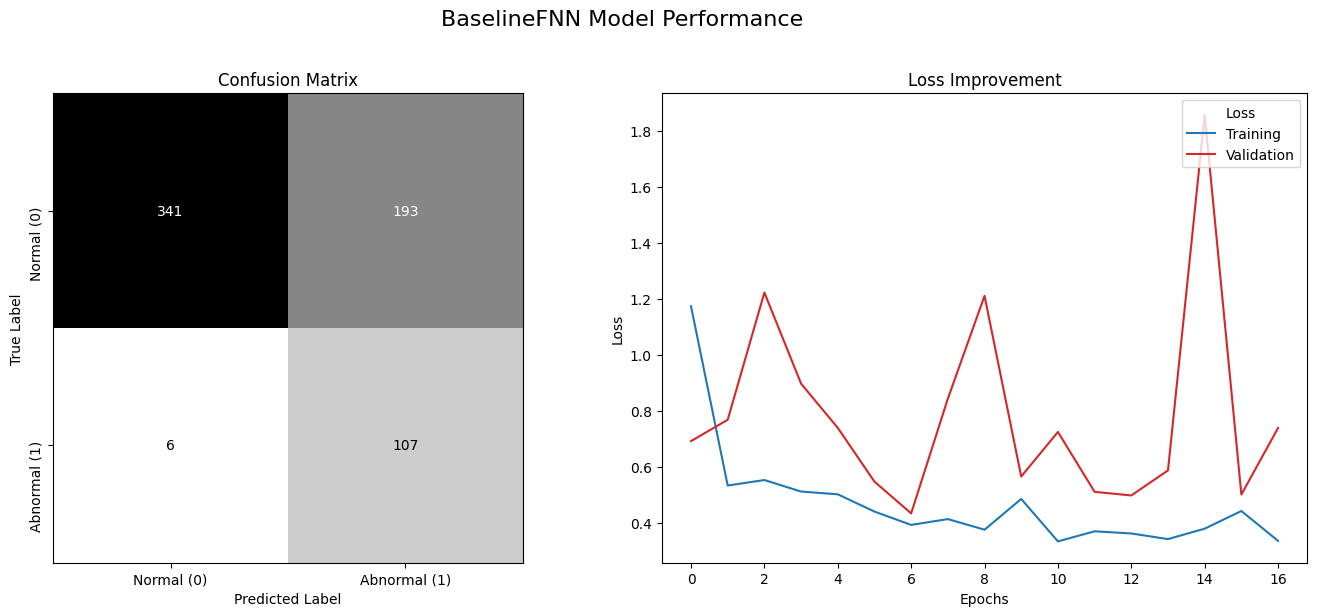

In [196]:
f1_BaselineFNN, rec_BaselineFNN, prec_BaselineFNN, f2_BaselineFNN, test_targets_BaselineFNN, test_preds_BaselineFNN = evaluate_model(model_BaselineFNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_BaselineFNN*100:.2f}%")

cm = confusion_matrix(test_targets_BaselineFNN, test_preds_BaselineFNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_BaselineFNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_BaselineFNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('BaselineFNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'BaselineFNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Enhanced FNN

In [197]:
class EnhancedFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1680)
        self.fc2 = nn.Linear(1680, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

model = EnhancedFNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

EnhancedFNN(
  (fc1): Linear(in_features=16384, out_features=1680, bias=True)
  (fc2): Linear(in_features=1680, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [198]:
model_name = "EnhancedFNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_EnhancedFNN, train_loss_EnhancedFNN, val_loss_EnhancedFNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                                               criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                                               patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_EnhancedFNN, val_loss=val_loss_EnhancedFNN)

In [199]:
model = EnhancedFNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_EnhancedFNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_EnhancedFNN = data["train_loss"]
    val_loss_EnhancedFNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.96      0.81      0.88       534
Abnormal (1)       0.49      0.84      0.62       113

    accuracy                           0.82       647
   macro avg       0.72      0.83      0.75       647
weighted avg       0.88      0.82      0.83       647

F-Beta Score (test set): 73.42%


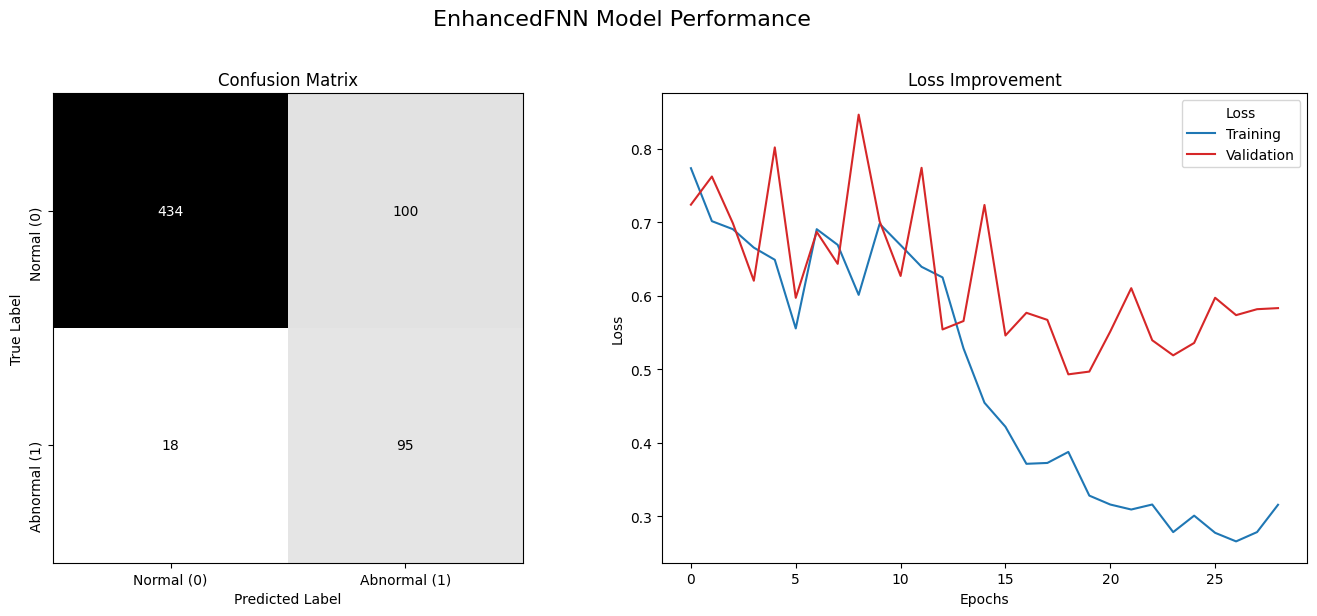

In [200]:
f1_EnhancedFNN, rec_EnhancedFNN, prec_EnhancedFNN, f2_EnhancedFNN, test_targets_EnhancedFNN, test_preds_EnhancedFNN = evaluate_model(model_EnhancedFNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_EnhancedFNN*100:.2f}%")

cm = confusion_matrix(test_targets_EnhancedFNN, test_preds_EnhancedFNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_EnhancedFNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_EnhancedFNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('EnhancedFNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'EnhancedFNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Baseline CNN

In [201]:
class BaselineCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaselineCNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

BaselineCNN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


In [202]:
model_name = "BaselineCNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_BaselineCNN, train_loss_BaselineCNN, val_loss_BaselineCNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_BaselineCNN, val_loss=val_loss_BaselineCNN)

In [203]:
model = BaselineCNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_BaselineCNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_BaselineCNN = data["train_loss"]
    val_loss_BaselineCNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.98      0.81      0.89       534
Abnormal (1)       0.50      0.91      0.65       113

    accuracy                           0.83       647
   macro avg       0.74      0.86      0.77       647
weighted avg       0.89      0.83      0.84       647

F-Beta Score (test set): 78.39%


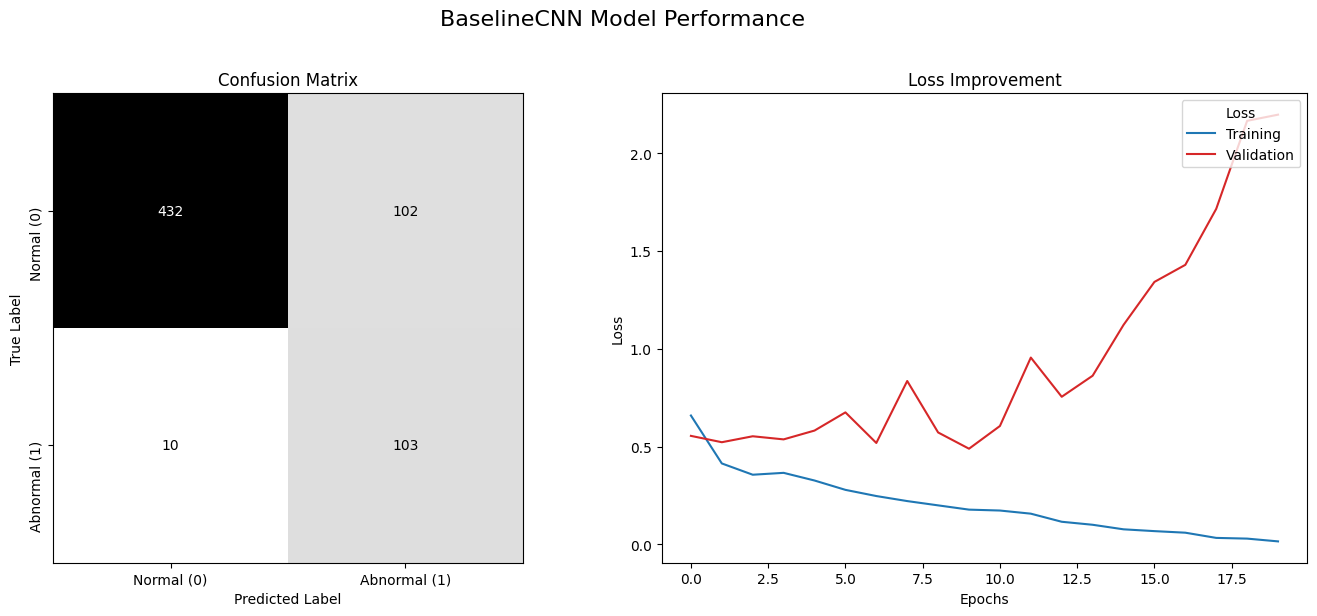

In [204]:
f1_BaselineCNN, rec_BaselineCNN, prec_BaselineCNN, f2_BaselineCNN, test_targets_BaselineCNN, test_preds_BaselineCNN = evaluate_model(model_BaselineCNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_BaselineCNN*100:.2f}%")

cm = confusion_matrix(test_targets_BaselineCNN, test_preds_BaselineCNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_BaselineCNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_BaselineCNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('BaselineCNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'BaselineCNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Medium CNN

In [205]:
class MediumCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MediumCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, num_classes)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        
model = MediumCNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

MediumCNN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [206]:
model_name = "MediumCNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_MediumCNN, train_loss_MediumCNN, val_loss_MediumCNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_MediumCNN, val_loss=val_loss_MediumCNN)

In [207]:
model = MediumCNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_MediumCNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_MediumCNN = data["train_loss"]
    val_loss_MediumCNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.99      0.70      0.82       534
Abnormal (1)       0.40      0.96      0.57       113

    accuracy                           0.74       647
   macro avg       0.69      0.83      0.69       647
weighted avg       0.88      0.74      0.77       647

F-Beta Score (test set): 74.90%


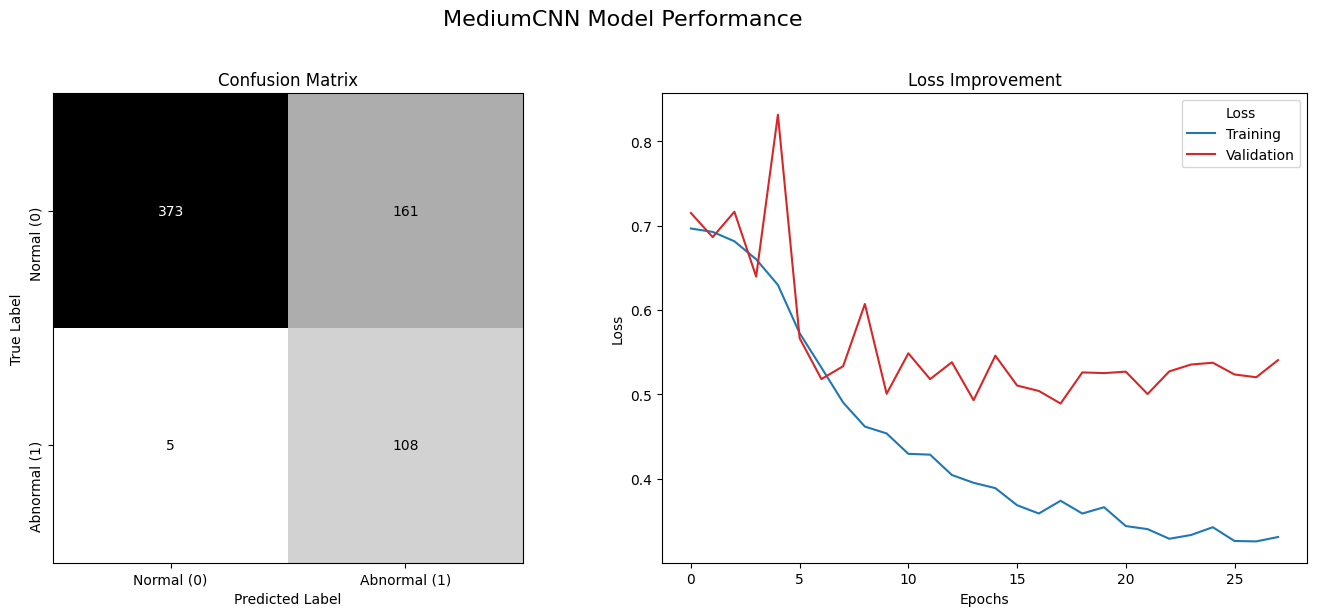

In [208]:
f1_MediumCNN, rec_MediumCNN, prec_MediumCNN, f2_MediumCNN, test_targets_MediumCNN, test_preds_MediumCNN = evaluate_model(model_MediumCNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_MediumCNN*100:.2f}%")

cm = confusion_matrix(test_targets_MediumCNN, test_preds_MediumCNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_MediumCNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_MediumCNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('MediumCNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'MediumCNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Enhanced CNN

In [209]:
class EnhancedCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((2,2))
        
        self.fc1 = nn.Linear(256, 16)
        self.fc2 = nn.Linear(16, num_classes)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        
model = EnhancedCNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

EnhancedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(2, 2))
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [210]:
model_name = "EnhancedCNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_EnhancedCNN, train_loss_EnhancedCNN, val_loss_EnhancedCNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_EnhancedCNN, val_loss=val_loss_EnhancedCNN)

In [211]:
model = EnhancedCNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_EnhancedCNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_EnhancedCNN = data["train_loss"]
    val_loss_EnhancedCNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.96      0.87      0.92       534
Abnormal (1)       0.58      0.83      0.69       113

    accuracy                           0.87       647
   macro avg       0.77      0.85      0.80       647
weighted avg       0.90      0.87      0.88       647

F-Beta Score (test set): 76.67%


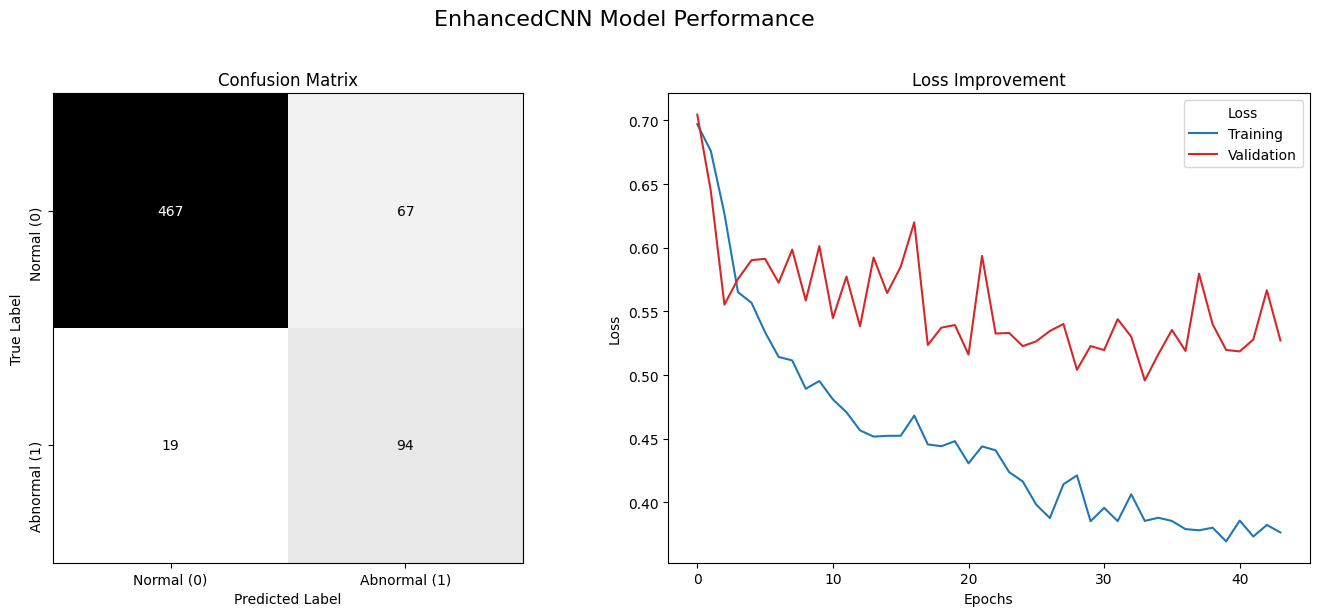

In [212]:
f1_EnhancedCNN, rec_EnhancedCNN, prec_EnhancedCNN, f2_EnhancedCNN, test_targets_EnhancedCNN, test_preds_EnhancedCNN = evaluate_model(model_EnhancedCNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_EnhancedCNN*100:.2f}%")

cm = confusion_matrix(test_targets_EnhancedCNN, test_preds_EnhancedCNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_EnhancedCNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_EnhancedCNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('EnhancedCNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'EnhancedCNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

###  Squeeze Excitation CNN

In [213]:
class se_block(nn.Module):
    """
    Squeeze-and-excitation block for channel-wise feature recalibration.
    """
    def __init__(self, channel, reduction=16):
        super(se_block, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Squeeze
        y = self.gap(x).view(b, c) 
        
        # Excitation
        z = self.fc(y).view(b, c, 1, 1)

        out = x * z.expand_as(x)
        return out
    
class seCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(seCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = se_block(32, reduction=8)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = se_block(64, reduction=8)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) 
        
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, num_classes)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.se1(self.pool(self.relu(self.bn1(self.conv1(x)))))
        x = self.se2(self.pool(self.relu(self.bn2(self.conv2(x)))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = seCNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

seCNN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se1): se_block(
    (gap): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=32, out_features=4, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=4, out_features=32, bias=False)
      (3): Sigmoid()
    )
  )
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se2): se_block(
    (gap): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=8, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=64, bias=False)
      (3): Sigmoid()
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_fea

In [214]:
model_name = "seCNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_seCNN, train_loss_seCNN, val_loss_seCNN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_seCNN, val_loss=val_loss_seCNN)

In [215]:
model = seCNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_seCNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_seCNN = data["train_loss"]
    val_loss_seCNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.97      0.69      0.81       534
Abnormal (1)       0.38      0.88      0.53       113

    accuracy                           0.72       647
   macro avg       0.67      0.79      0.67       647
weighted avg       0.86      0.72      0.76       647

F-Beta Score (test set): 69.74%


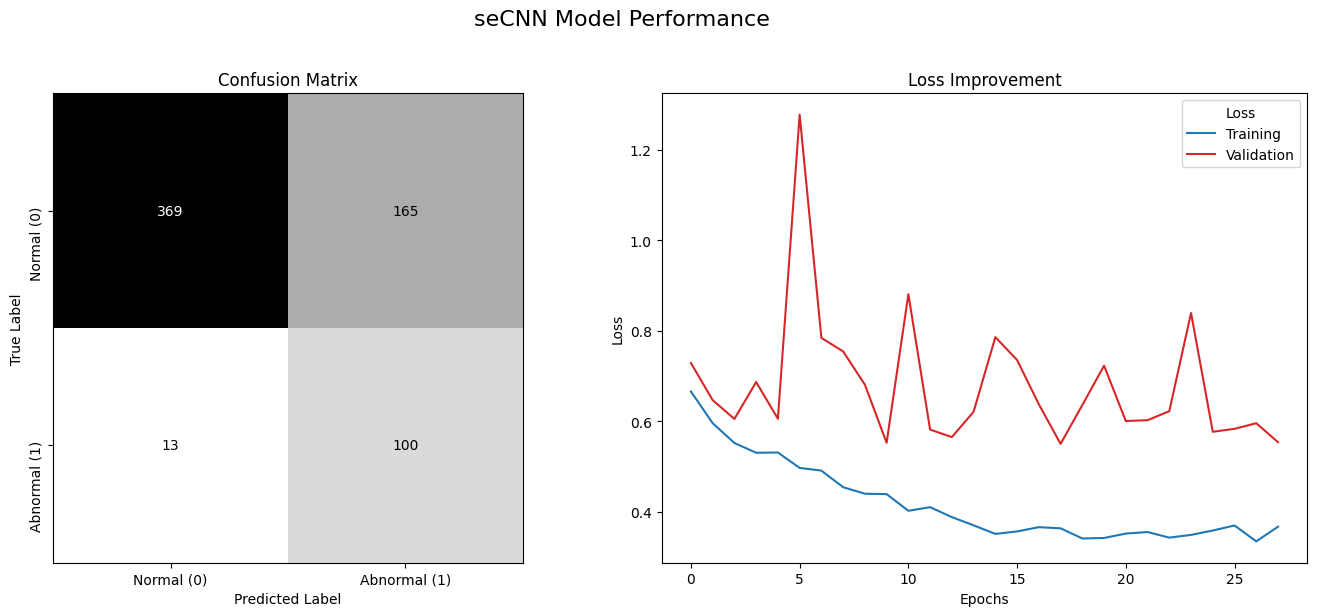

In [216]:
f1_seCNN, rec_seCNN, prec_seCNN, f2_seCNN, test_targets_seCNN, test_preds_seCNN = evaluate_model(model_seCNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_seCNN*100:.2f}%")

cm = confusion_matrix(test_targets_seCNN, test_preds_seCNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_seCNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_seCNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('seCNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'seCNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Feature Fusion Network

In [217]:
class DFFN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DFFN, self).__init__()
        
        # --- PATH 1: Low-Level CNN (Focus: Edges and Texture) ---
        # Shallow path, small kernel sizes, similar to what HOG/LBP looks for.
        self.conv_low = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn_low = nn.BatchNorm2d(16)
        self.pool_low = nn.MaxPool2d(kernel_size=2, stride=2) # 16 channels, size 64x64
        self.gap_low = nn.AdaptiveAvgPool2d((1, 1)) # Output: 16 features

        # --- PATH 2: High-Level CNN (Focus: Global Semantics) ---
        # Deeper path, larger kernels to capture broad frequency/time segments.
        self.conv_high_1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.bn_high_1 = nn.BatchNorm2d(32)
        self.pool_high_1 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 channels, size 60x60 approx
        
        self.conv_high_2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.bn_high_2 = nn.BatchNorm2d(64)
        self.gap_high = nn.AdaptiveAvgPool2d((1, 1)) # Output: 64 features

        # --- PATH 3: Global Feature (FNN Equivalent) ---
        # Flattened input to capture pixel relationships (like the Enhanced FNN)
        self.fc_global_1 = nn.Linear(128 * 128, 128)
        self.bn_global_1 = nn.BatchNorm1d(128)
        self.dropout_global = nn.Dropout(0.5) # High dropout here to prevent FNN path overfitting
        # Output: 128 features

        # --- FUSION AND CLASSIFICATION HEAD ---
        # Total Features = 16 (Low) + 64 (High) + 128 (Global) = 208 features
        self.dropout_fusion = nn.Dropout(0.5)
        self.fc_fusion = nn.Linear(16 + 64 + 128 , 64)
        self.fc_final = nn.Linear(64, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # --- PATH 1: Low-Level CNN ---
        x_low = self.pool_low(self.relu(self.bn_low(self.conv_low(x))))
        x_low = self.gap_low(x_low)
        x_low = x_low.view(x_low.size(0), -1)

        # --- PATH 2: High-Level CNN ---
        x_high = self.pool_high_1(self.relu(self.bn_high_1(self.conv_high_1(x))))
        x_high = self.relu(self.bn_high_2(self.conv_high_2(x_high)))
        x_high = self.gap_high(x_high)
        x_high = x_high.view(x_high.size(0), -1)

        # --- PATH 3: Global Feature (FNN) ---
        x_global = x.view(x.size(0), -1) # Flatten 128*128
        x_global = self.relu(self.bn_global_1(self.fc_global_1(x_global)))
        x_global = self.dropout_global(x_global)
        
        # --- FUSION ---
        x_fused = torch.cat((x_low, x_high, x_global), dim=1)
        
        # --- CLASSIFICATION ---
        x_fused = self.dropout_fusion(self.relu(self.fc_fusion(x_fused)))
        output = self.fc_final(x_fused)
        
        return output

model = DFFN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

DFFN(
  (conv_low): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_low): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_low): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap_low): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv_high_1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (bn_high_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_high_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_high_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn_high_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap_high): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc_global_1): Linear(in_features=16384, out_features=128, bias=True)
  (bn_global_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_global): Dropout(p=0.5, inplace=Fal

In [218]:
model_name = "DFFN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_DFFN, train_loss_DFFN, val_loss_DFFN = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                           criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                           patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_DFFN, val_loss=val_loss_DFFN)

In [219]:
model = DFFN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_DFFN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_DFFN = data["train_loss"]
    val_loss_DFFN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.98      0.84      0.90       534
Abnormal (1)       0.54      0.93      0.69       113

    accuracy                           0.85       647
   macro avg       0.76      0.88      0.79       647
weighted avg       0.91      0.85      0.87       647

F-Beta Score (test set): 81.40%


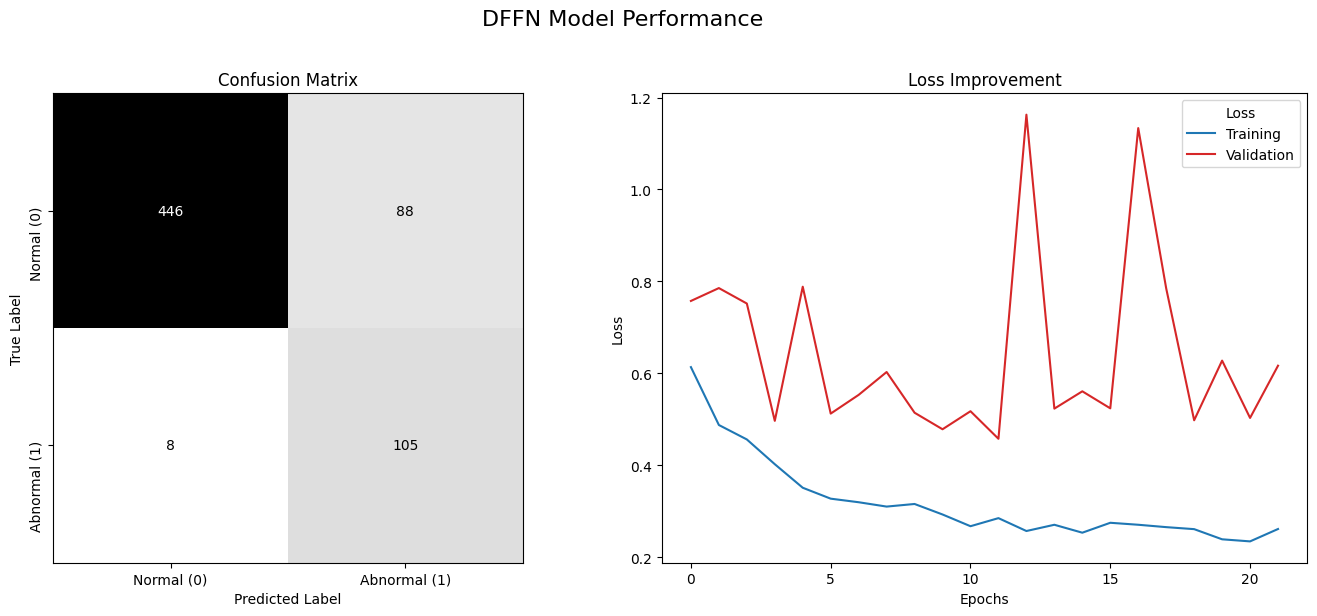

In [220]:
f1_DFFN, rec_DFFN, prec_DFFN, f2_DFFN, test_targets_DFFN, test_preds_DFFN = evaluate_model(model_DFFN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_DFFN*100:.2f}%")

cm = confusion_matrix(test_targets_DFFN, test_preds_DFFN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_DFFN, label='Training', color='tab:blue')
axes[1].plot(val_loss_DFFN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('DFFN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'DFFN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Data Augmented CNN

In [240]:
class AudioAugmentations(object):
    """Applies random frequency and time masking/shifting."""
    def __init__(self):
        self.time_masking = AT.TimeMasking(time_mask_param=8, p=0.3)
        self.freq_masking = AT.FrequencyMasking(freq_mask_param=8)
        
    def __call__(self, tensor):
        tensor = self.time_masking(tensor)
        tensor = self.freq_masking(tensor)
        if torch.rand(1) < 0.5:
             shift = torch.randint(-10, 10, (1,)).item()
             tensor = torch.roll(tensor, shifts=shift, dims=2)
        return tensor
    
train_transform = VT.Compose([
    VT.ToTensor(), 
    VT.Resize((IMG_H, IMG_W), antialias=True),
    VT.RandomRotation(5),
    VT.Normalize(mean=[0.5], std=[0.5]),
    AudioAugmentations()
])

val_test_transform = VT.Compose([
    VT.ToTensor(), 
    VT.Resize((IMG_H, IMG_W), antialias=True),
    VT.Normalize(mean=[0.5], std=[0.5])
])

train_dataset_aug = SpectrogramDataset(X_train.values, y_train.values, transform=train_transform)
val_dataset_aug = SpectrogramDataset(X_val, y_val, transform=val_test_transform)
test_dataset_aug = SpectrogramDataset(X_test, y_test, transform=val_test_transform)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE, shuffle=False)

In [242]:
class AugmentedCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AugmentedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(64, 16) 
        self.fc2 = nn.Linear(16, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = AugmentedCNN(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

AugmentedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [243]:
model_name = "AugmentedCNN"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 10
num_epochs = 50

# model_AugmentedCNN, train_loss_AugmentedCNN, val_loss_AugmentedCNN = train_model(model=model, train_loader=train_loader_aug, val_loader=val_loader_aug,
#                                                                                  criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                                                  patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_AugmentedCNN, val_loss=val_loss_AugmentedCNN)

Epoch 1/50: Train Loss: 0.6934 | Val Loss: 0.7236
Model checkpoint saved.
Epoch 2/50: Train Loss: 0.6921 | Val Loss: 0.7194
Model checkpoint saved.
Epoch 3/50: Train Loss: 0.6879 | Val Loss: 0.6724
Model checkpoint saved.
Epoch 4/50: Train Loss: 0.6821 | Val Loss: 0.7000
Epoch 5/50: Train Loss: 0.6717 | Val Loss: 0.7216
Epoch 6/50: Train Loss: 0.6322 | Val Loss: 0.7384
Epoch 7/50: Train Loss: 0.6067 | Val Loss: 0.7466
Epoch 8/50: Train Loss: 0.5852 | Val Loss: 0.6004
Model checkpoint saved.
Epoch 9/50: Train Loss: 0.5956 | Val Loss: 0.6781
Epoch 10/50: Train Loss: 0.5658 | Val Loss: 0.6157
Epoch 11/50: Train Loss: 0.5468 | Val Loss: 0.5630
Model checkpoint saved.
Epoch 12/50: Train Loss: 0.5396 | Val Loss: 0.5793
Epoch 13/50: Train Loss: 0.5325 | Val Loss: 0.6685
Epoch 14/50: Train Loss: 0.5394 | Val Loss: 0.5760
Epoch 15/50: Train Loss: 0.5333 | Val Loss: 0.6069
Epoch 16/50: Train Loss: 0.5195 | Val Loss: 0.6045
Epoch 17/50: Train Loss: 0.5104 | Val Loss: 0.5648
Epoch 18/50: Train Los

In [244]:
model = AugmentedCNN(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_AugmentedCNN = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_AugmentedCNN = data["train_loss"]
    val_loss_AugmentedCNN = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.99      0.67      0.80       534
Abnormal (1)       0.38      0.96      0.55       113

    accuracy                           0.72       647
   macro avg       0.69      0.82      0.67       647
weighted avg       0.88      0.72      0.76       647

F-Beta Score (test set): 73.95%


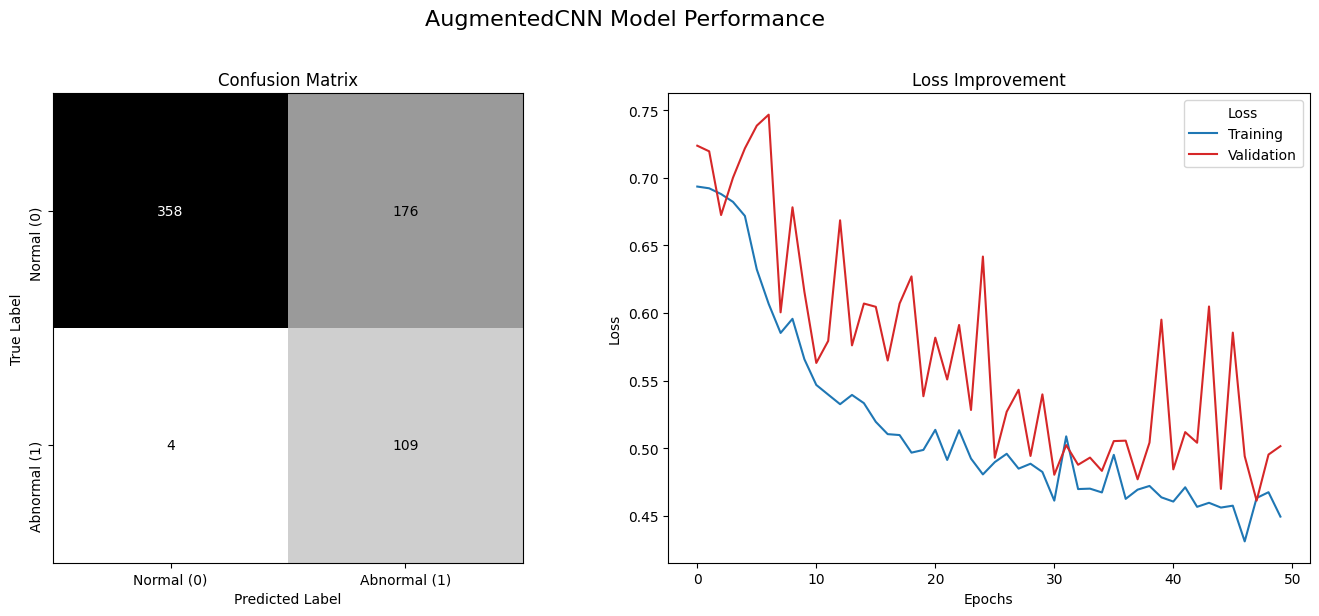

In [245]:
f1_AugmentedCNN, rec_AugmentedCNN, prec_AugmentedCNN, f2_AugmentedCNN, test_targets_AugmentedCNN, test_preds_AugmentedCNN = evaluate_model(model_AugmentedCNN, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_AugmentedCNN*100:.2f}%")

cm = confusion_matrix(test_targets_AugmentedCNN, test_preds_AugmentedCNN)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_AugmentedCNN, label='Training', color='tab:blue')
axes[1].plot(val_loss_AugmentedCNN, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('AugmentedCNN Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'AugmentedCNN_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### DL Performance Summary

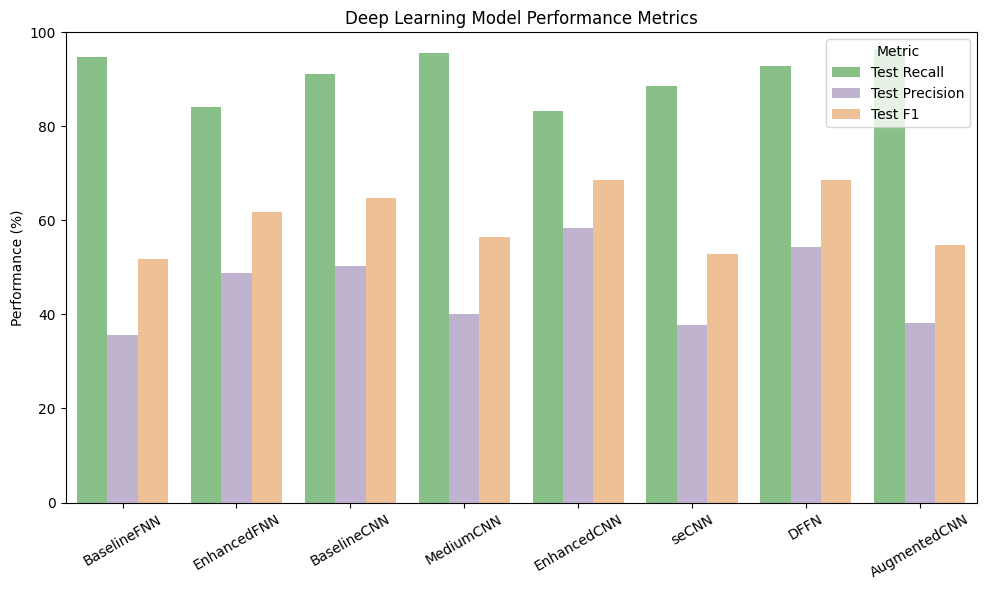

In [266]:
metrics_DL = pd.DataFrame({
    'Model': ['BaselineFNN', 'EnhancedFNN', 'BaselineCNN', 'MediumCNN', 'EnhancedCNN', 'seCNN', 'DFFN', 'AugmentedCNN'],
    'Test Recall': [rec_BaselineFNN * 100, rec_EnhancedFNN * 100, rec_BaselineCNN * 100, rec_MediumCNN * 100, rec_EnhancedCNN * 100, rec_seCNN * 100, rec_DFFN * 100, rec_AugmentedCNN * 100],
    'Test Precision': [prec_BaselineFNN * 100, prec_EnhancedFNN * 100, prec_BaselineCNN * 100, prec_MediumCNN * 100, prec_EnhancedCNN * 100, prec_seCNN * 100, prec_DFFN * 100, prec_AugmentedCNN * 100],
    'Test F1': [f1_BaselineFNN * 100, f1_EnhancedFNN * 100, f1_BaselineCNN * 100, f1_MediumCNN * 100, f1_EnhancedCNN * 100, f1_seCNN * 100, f1_DFFN * 100, f1_AugmentedCNN * 100]
})

# plot the all metrics, x: Model, y: value
metrics_melted = metrics_DL.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Model', y='Value', hue='Metric', palette='Accent')
plt.title('Deep Learning Model Performance Metrics')
plt.ylabel('Performance (%)')
plt.ylim(0, 100)
plt.legend(title='Metric', loc='upper right')
plt.xlabel('')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'DL_metric_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

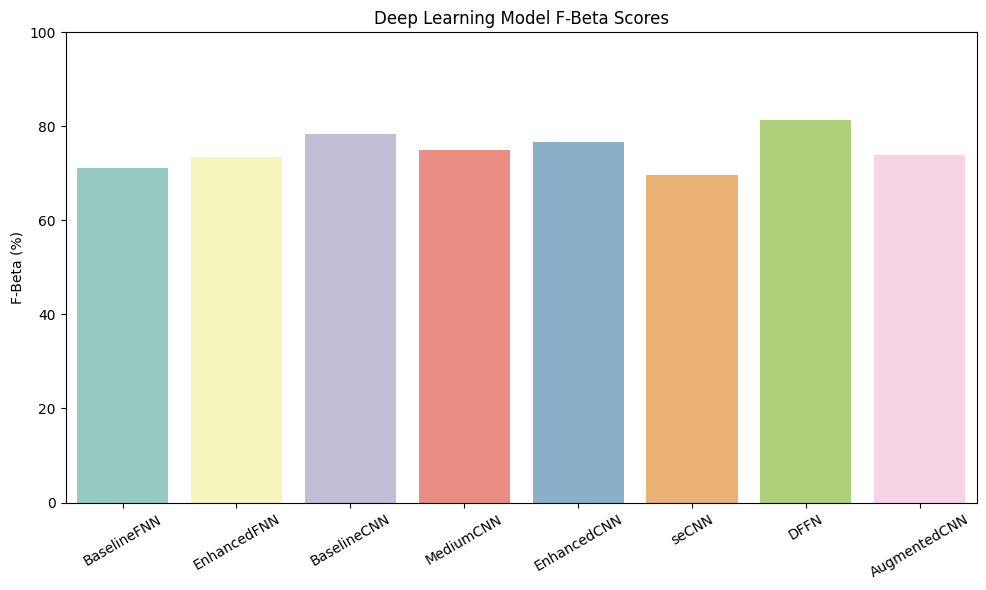

In [264]:
fbeta_metrics = pd.DataFrame({
    'Model': ['BaselineFNN', 'EnhancedFNN', 'BaselineCNN', 'MediumCNN', 'EnhancedCNN', 'seCNN', 'DFFN', 'AugmentedCNN'],
    'Test Set': [f2_BaselineFNN * 100, f2_EnhancedFNN * 100, f2_BaselineCNN * 100, f2_MediumCNN * 100, f2_EnhancedCNN * 100, f2_seCNN * 100, f2_DFFN * 100, f2_AugmentedCNN * 100]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=fbeta_metrics, x='Model', y='Test Set', palette='Set3')
plt.title('Deep Learning Model F-Beta Scores')
plt.ylabel('F-Beta (%)')
plt.ylim(0, 100)
plt.xlabel('')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DL_DIR, 'DL_fbeta_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

## **Pre-Trained Transfer Learning**

### Baseline Resnet Model

In [290]:
class BaselineResnetTransfer(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaselineResnetTransfer, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        og_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = og_conv1.weight.data[:, 0, :, :].unsqueeze(1)
        
        num_feats = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_feats, num_classes)
        
        for name, param in self.resnet.named_parameters():
            if "fc" not in name:
                param.requires_grad = False
            
    def forward(self, x):
        return self.resnet(x)
    
model = BaselineResnetTransfer(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

BaselineResnetTransfer(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [291]:
model_name = "BaselineResnetTransfer"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
patience = 50
num_epochs = 50

# model_BaselineResnetTransfer, train_loss_BaselineResnetTransfer, val_loss_BaselineResnetTransfer = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                                                        criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                                                        patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_BaselineResnetTransfer, val_loss=val_loss_BaselineResnetTransfer)

In [293]:
model = BaselineResnetTransfer(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_BaselineResnetTransfer = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_BaselineResnetTransfer = data["train_loss"]
    val_loss_BaselineResnetTransfer = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.96      0.83      0.89       534
Abnormal (1)       0.51      0.83      0.64       113

    accuracy                           0.83       647
   macro avg       0.74      0.83      0.76       647
weighted avg       0.88      0.83      0.85       647

F-Beta Score (test set): 74.02%


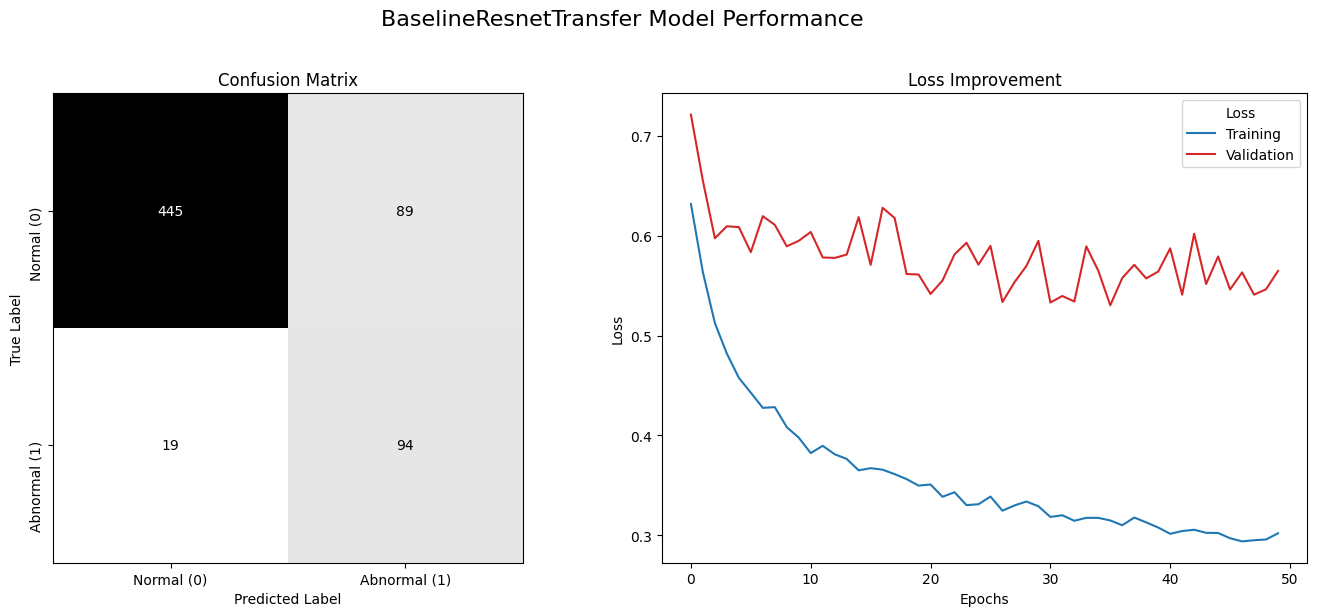

In [294]:
f1_BaselineResnetTransfer, rec_BaselineResnetTransfer, prec_BaselineResnetTransfer, f2_BaselineResnetTransfer, test_targets_BaselineResnetTransfer, test_preds_BaselineResnetTransfer = evaluate_model(model_BaselineResnetTransfer, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_BaselineResnetTransfer*100:.2f}%")

cm = confusion_matrix(test_targets_BaselineResnetTransfer, test_preds_BaselineResnetTransfer)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_BaselineResnetTransfer, label='Training', color='tab:blue')
axes[1].plot(val_loss_BaselineResnetTransfer, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('BaselineResnetTransfer Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_TL_DIR, 'BaselineResnetTransfer_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### Enhanced Resnet Model

In [295]:
class EnhancedResnetTransfer(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedResnetTransfer, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        og_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = og_conv1.weight.data[:, 0, :, :].unsqueeze(1)
        
        num_feats = self.resnet.fc.in_features
        
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_feats, num_classes)
        )
                
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for name, param in self.resnet.named_parameters():
            if "layer4" in name or "layer3" in name or "fc" in name:
                param.requires_grad = True

        for m in self.resnet.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.requires_grad = True
                m.bias.requires_grad = True
            
    def forward(self, x):
        return self.resnet(x)
    
model = EnhancedResnetTransfer(INPUT_SIZE, NUM_CLASSES)
model.to(DEVICE)
print(model)

EnhancedResnetTransfer(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [296]:
model_name = "EnhancedResnetTransfer"
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.005)
patience = 10
num_epochs = 50

# model_EnhancedResnetTransfer, train_loss_EnhancedResnetTransfer, val_loss_EnhancedResnetTransfer = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
#                                                                                                                criterion=criterion, optimizer=optimizer, epochs=num_epochs,
#                                                                                                                patience=patience, model_name=model_name)

# np.savez(f'../model/{model_name}/{model_name}_losses.npz', train_loss=train_loss_EnhancedResnetTransfer, val_loss=val_loss_EnhancedResnetTransfer)

### 

In [297]:
model = EnhancedResnetTransfer(INPUT_SIZE, NUM_CLASSES)
state_dict = torch.load(f'../model/{model_name}/{model_name}.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(DEVICE)
model_EnhancedResnetTransfer = model

with np.load(f"../model/{model_name}/{model_name}_losses.npz") as data:
    train_loss_EnhancedResnetTransfer = data["train_loss"]
    val_loss_EnhancedResnetTransfer = data["val_loss"]

              precision    recall  f1-score   support

  Normal (0)       0.98      0.85      0.91       534
Abnormal (1)       0.56      0.92      0.70       113

    accuracy                           0.86       647
   macro avg       0.77      0.88      0.80       647
weighted avg       0.91      0.86      0.87       647

F-Beta Score (test set): 81.63%


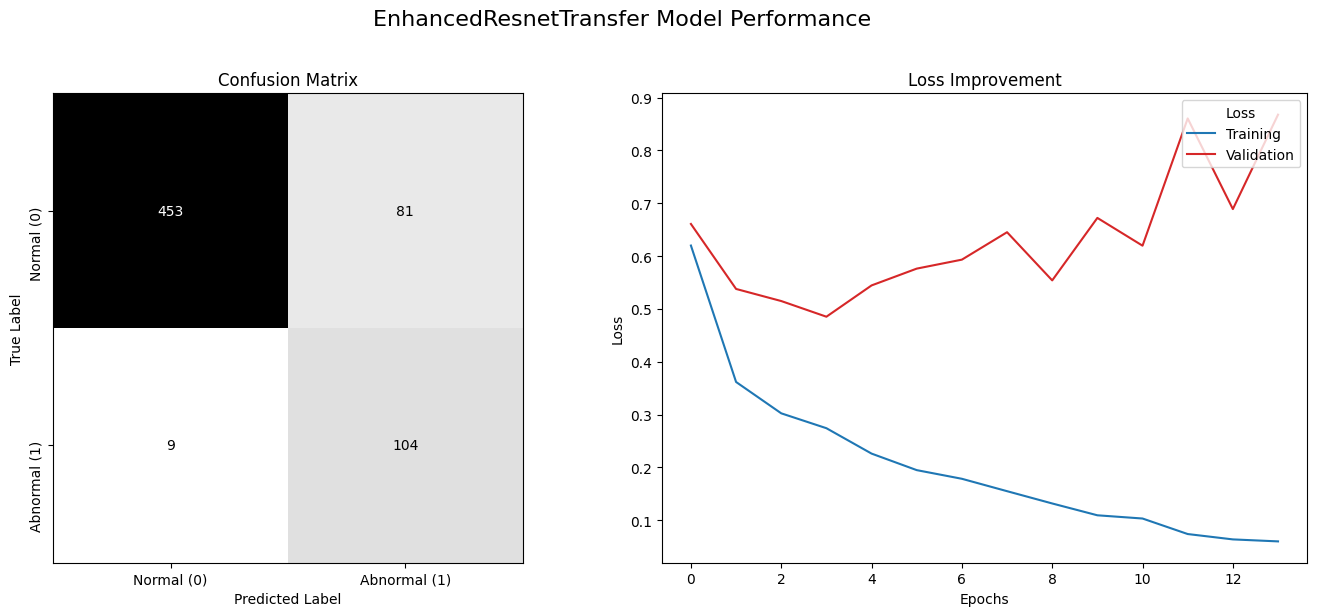

In [298]:
f1_EnhancedResnetTransfer, rec_EnhancedResnetTransfer, prec_EnhancedResnetTransfer, f2_EnhancedResnetTransfer, test_targets_EnhancedResnetTransfer, test_preds_EnhancedResnetTransfer = evaluate_model(model_EnhancedResnetTransfer, test_loader, name="Test")

print(f"F-Beta Score (test set): {f2_EnhancedResnetTransfer*100:.2f}%")

cm = confusion_matrix(test_targets_EnhancedResnetTransfer, test_preds_EnhancedResnetTransfer)
vis = ConfusionMatrixDisplay(cm, display_labels=['Normal (0)', 'Abnormal (1)'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

vis.plot(cmap="Grays", values_format='d', colorbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].yaxis.set_tick_params(rotation=90)
axes[0].tick_params(axis='x')

axes[1].plot(train_loss_EnhancedResnetTransfer, label='Training', color='tab:blue')
axes[1].plot(val_loss_EnhancedResnetTransfer, label='Validation', color='tab:red')
axes[1].set_title('Loss Improvement')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend(title="Loss", loc='upper right')

plt.suptitle('EnhancedResnetTransfer Model Performance', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_TL_DIR, 'EnhancedResnetTransfer_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

### TL Performance Summary

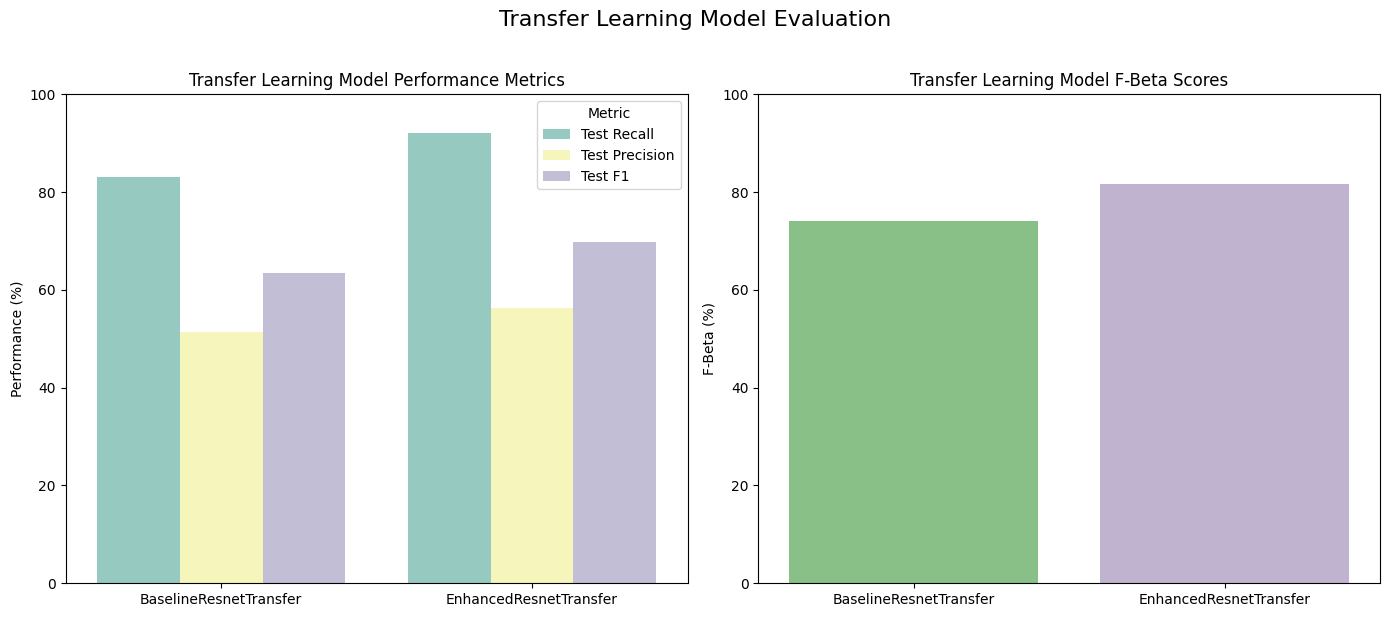

In [307]:
metrics_TL = pd.DataFrame({
    'Model': ['BaselineResnetTransfer', 'EnhancedResnetTransfer'],
    'Test Recall': [rec_BaselineResnetTransfer * 100, rec_EnhancedResnetTransfer * 100],
    'Test Precision': [prec_BaselineResnetTransfer * 100, prec_EnhancedResnetTransfer * 100],
    'Test F1': [f1_BaselineResnetTransfer * 100, f1_EnhancedResnetTransfer * 100]
})

fbeta_metrics = pd.DataFrame({
    'Model': ['BaselineResnetTransfer', 'EnhancedResnetTransfer'],
    'Test Set': [f2_BaselineResnetTransfer * 100, f2_EnhancedResnetTransfer * 100]
})

# plot side by side (left plot: metrics), (right plot: fbeta)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_melted = metrics_TL.melt(id_vars='Model', var_name='Metric', value_name='Value')
sns.barplot(data=metrics_melted, x='Model', y='Value', hue='Metric', palette='Set3', ax=axes[0])
axes[0].set_title('Transfer Learning Model Performance Metrics')
axes[0].set_ylabel('Performance (%)')
axes[0].set_ylim(0, 100)
axes[0].legend(title='Metric', loc='upper right')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x')

sns.barplot(data=fbeta_metrics, x='Model', y='Test Set', palette='Accent', ax=axes[1])
axes[1].set_title('Transfer Learning Model F-Beta Scores')
axes[1].set_ylabel('F-Beta (%)')
axes[1].set_ylim(0, 100)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x')

plt.suptitle('Transfer Learning Model Evaluation', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIG_TL_DIR, 'TL_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

## **Model Choice & Evaluation**